In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import glob

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

from seaborn import clustermap
import matplotlib.pyplot as plt

import plotly.express as px

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from modules.hmm import get_hits, get_seqs

In [3]:

import seaborn as sns
sns.set(font_scale=0.25)

In [4]:
DATA_DIR = "../data/runs/aquificota/2024-10-08/"

SOURCES = ["barosa"]

E_VALUE_THR = 1e-5
ABSENCE_THR = 0.90
CORE_THR    = 0.75

CLUSTERMAP_METHOD = "ward"
CLUSTERMAP_METRIC = "braycurtis"

RANDOM_SEED = 666

## Raw data

In [5]:
hits_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA_hmmer.txt"
)
seqs_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA.fa"
)

hits_df = get_hits(hits_path)
seqs_df = get_seqs(seqs_path)

hits_df = pd.merge(
    left=hits_df,
    right=seqs_df.rename(columns={"seq_id": "target_name"}),
    how="left",
    on="target_name"
)

# Create MAG and gene caller ID columns
hits_df["mag"] = hits_df["target_name"]\
    .str.split("_").str[:-1]\
    .apply(lambda row: "_".join(row))
hits_df["gene_caller_id"] = hits_df["target_name"]\
    .str.split("_").str[-1]

hits_df

target_name target_accession  \
0              Desulfurobacterium_atlanticum_DSM_15668_32                -   
1                       Thermocrinis_jamiesonii_GBS1_1354                -   
2                         Thermocrinis_sp_CTOTU25738_1171                -   
3              Desulfurobacterium_atlanticum_DSM_15668_26                -   
4       Hydrogenothermaceae_bacterium_356_308_metabat2...                -   
...                                                   ...              ...   
109341  Aquificaceae_bacterium_S012_metabat2_scaf2bin_...                -   
109342  Aquificaceae_bacterium_S139_metabat1_scaf2bin_...                -   
109343            Aquificaceae_bacterium_S140_64_esom_657                -   
109344  Aquificaceae_bacterium_S140_metabat1_scaf2bin_...                -   
109345  Aquificaceae_bacterium_S146_metabat1_scaf2bin_...                -   

                                query_name query_accession  e_value_full_seq  \
0       barosa_FbpC-iron_uptake_ATPase-rep               -     5.200000e-109   
1       barosa_FbpC-iron_uptake_ATPase-rep               -     1.400000e-107   
2       barosa_FbpC-iron_uptake_ATPase-rep               -     2.500000e-107   
3       barosa_FbpC-iron_uptake_ATPase-rep               -      9.300000e-95   
4       barosa_FbpC-iron_uptake_ATPase-rep               -      1.300000e-93   
...                                    ...             ...               ...   
109341                       barosa_K01959               -      4.600000e+00   
109342                       barosa_K01959               -      4.600000e+00   
109343                       barosa_K01959               -      4.600000e+00   
109344                       barosa_K01959               -      4.600000e+00   
109345                       barosa_K01959               -      4.600000e+00   

        score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
0                367.8            0.1     1.800000e-108           366.1   
1                363.2            0.0     1.700000e-107           362.9   
2                362.3            0.0     3.400000e-107           361.9   
3                321.0            0.0      2.300000e-93           316.4   
4                317.2            0.0      1.600000e-93           316.9   
...                ...            ...               ...             ...   
109341             9.5            0.0      7.000000e+00             8.9   
109342             9.5            0.0      7.000000e+00             8.9   
109343             9.5            0.0      7.000000e+00             8.9   
109344             9.5            0.0      7.000000e+00             8.9   
109345             9.5            0.0      7.000000e+00             8.9   

        bias_best_dom  ...  clu  ov  env  dom  rep  inc  \
0                 0.1  ...    1   0    1    1    1    1   
1                 0.0  ...    0   0    1    1    1    1   
2                 0.0  ...    0   0    1    1    1    1   
3                 0.0  ...    1   0    1    1    1    1   
4                 0.0  ...    0   0    1    1    1    1   
...               ...  ...  ...  ..  ...  ...  ...  ...   
109341            0.0  ...    0   0    1    1    1    0   
109342            0.0  ...    0   0    1    1    1    0   
109343            0.0  ...    0   0    1    1    1    0   
109344            0.0  ...    0   0    1    1    1    0   
109345            0.0  ...    0   0    1    1    1    0   

        description_of_target  \
0                           -   
1                           -   
2                           -   
3                           -   
4                           -   
...                       ...   
109341                      -   
109342                      -   
109343                      -   
109344                      -   
109345                      -   

                                                      seq  \
0       MGVLVLENVRKSYKDVEILKRISLDVEKGEFLTLLGPSGCGKTTTL...   
1       MWKWDSSEVHL

## Preprocessing

In [6]:
# Filter by selected source
hits_df = hits_df[hits_df["query_name"].str.startswith(tuple(SOURCES))]

# Filter by e-value threshold
hits_df = hits_df[hits_df["e_value_full_seq"] <= E_VALUE_THR]

# Get only those hits with the lowest E-value
hits_df = hits_df.loc[
    hits_df.groupby("target_name")["e_value_full_seq"].idxmin()
].reset_index(drop=True)

hits_df["query_name"] = hits_df["query_name"].str.replace("barosa_", "")

hits_df

target_name target_accession  \
0                         Aquifex_aeolicus_HyVt_501_1051                -   
1                         Aquifex_aeolicus_HyVt_501_1054                -   
2                         Aquifex_aeolicus_HyVt_501_1074                -   
3                         Aquifex_aeolicus_HyVt_501_1076                -   
4                         Aquifex_aeolicus_HyVt_501_1111                -   
...                                                  ...              ...   
22782  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
22783  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
22784  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
22785  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
22786  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   

                       query_name query_accession  e_value_full_seq  \
0      barosa_fefe-group-c2.mafft               -      6.700000e-22   
1      barosa_fefe-group-c2.mafft               -      5.600000e-06   
2      barosa_fefe-group-c2.mafft               -      5.900000e-13   
3      barosa_fefe-group-c2.mafft               -      1.400000e-31   
4                   barosa_K21308               -     2.000000e-106   
...                           ...             ...               ...   
22782            barosa_arsC_thio               -      2.600000e-29   
22783            barosa_TIGR02891       TIGR02891     5.100000e-173   
22784            barosa_TIGR02866       TIGR02866      4.900000e-48   
22785               barosa_K02299               -      4.700000e-26   
22786               barosa_FeoB_N      PF02421.13      6.200000e-09   

       score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
0                81.7            6.0      8.400000e-22            81.4   
1                29.1            0.0      9.400000e-06            28.4   
2                52.2            0.7      7.800000e-13            51.8   
3               113.8           61.4      2.200000e-17            66.8   
4               359.3            5.8     2.300000e-106           359.2   
...               ...            ...               ...             ...   
22782           105.9            0.0      3.000000e-29           105.7   
22783           580.3           44.0     5.900000e-173           580.1   
22784           167.3            3.7      7.200000e-48           166.7   
22785            95.7           21.3      4.700000e-26            95.7   
22786            39.5            0.2      2.700000e-08            37.4   

       bias_best_dom  ...  clu  ov  env  dom  rep  inc  description_of_target  \
0                6.0  ...    0   0    1    1    1    1                      -   
1                0.0  ...    0   0    1    1    1    1                      -   
2                0.7  ...    0   0    1    1    1    1                      -   
3               27.6  ...    1   1    2    2    2    2                      -   
4                5.8  ...    0   0    1    1    1    1                      -   
...              ...  ...  ...  ..  ...  ...  ...  ...                    ...   
22782            0.0  ...    0   0    1    1    1    1                      -   
22783           44.0  ...    0   0    1    1    1    1                      -   
22784            3.7  ...    0   0    1    1    1    1                      -   
22785           21.3  ...    1   0    1    1    1    1                      -   
22786            0.2  ...    1   0    1    1    1    1                      -   

                                                     seq  \
0      MFTKGEDTERQEERMEGAELENLKREVERLREELRTKDEECERLRR...   
1      MKALRKSFRLKVTLAFLIVGLIPYVIFSLFSIAQMEKALRERIEYD...   
2      MAKVKGEEFLRLTKMIANTAQATSEFLSDSCLVDLDEIFGNVLNKL...   
3      MKEILPPQESGAARRAMSGANQRRRERTSAKKQALVEKLASASEEV...   
4      MPQFALVIDLNVCVGCHACAVNCKEWNTQASFGPLSDYDPYGREPH...   
...                                          

#### Saving sequences for each HMM

In [28]:
sequences_dir = os.path.join(
    DATA_DIR,
    "sequences"
)
os.makedirs(sequences_dir, exist_ok=True)

for hmm_model in hits_df["query_name"].unique():

    hmm_path = os.path.join(
        sequences_dir,
        f"{hmm_model}.fasta"
    )

    hmm_df = hits_df[hits_df["query_name"] == hmm_model]

    hmm_seqs = [
        SeqRecord(
            Seq(row["seq"]),
            id=row["target_name"],
            name="",
            description="",
        )
        for _, row in hmm_df.iterrows()
    ]

    SeqIO.write(hmm_seqs, hmm_path, "fasta")


#### Creating the heatmap dataframe

In [29]:
# Presence/abscence (remove for having the counts of many-vs-many)
heat_df = hits_df[["mag", "query_name"]].copy()

heat_df = heat_df.rename(columns={"query_name": "profile"})
heat_df = heat_df\
    .value_counts()\
    .reset_index(drop=False)\
    .rename(columns={0: "count"})

# Add collumn for displaying presence/absence
heat_df["presence"] = heat_df["count"].apply(lambda row: int(bool(row)))

# Filter profiles
heat_df["source"] = heat_df["profile"].str.split("_").str[0]

heat_df = heat_df.pivot(
    index="mag",
    columns="profile",
    values="presence"
)

# Format columns
heat_df.columns = heat_df.columns.str.replace("barosa.source.hmm_", "barosa_")

# Fill NaNs
heat_df = heat_df.fillna(0.0)

heat_df

profile                                             Carb_anhydrase  Cyc1  \
mag                                                                        
Aquifex_aeolicus_HyVt_501                                      1.0   0.0   
Aquifex_aeolicus_SZUA_1413                                     0.0   0.0   
Aquifex_aeolicus_SZUA_1501                                     0.0   0.0   
Aquifex_aeolicus_SZUA_1519                                     0.0   0.0   
Aquifex_aeolicus_VF5                                           0.0   0.0   
...                                                            ...   ...   
Thermovibrio_sp_S012_127_esom                                  0.0   0.0   
Thermovibrio_sp_S141_83                                        0.0   0.0   
Venenivibrio_stagnispumantis_DSM_18763                         0.0   0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...             0.0   0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...             0.0   0.0   

profile                                             Cyc2_repCluster1  \
mag                                                                    
Aquifex_aeolicus_HyVt_501                                        1.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   
Aquifex_aeolicus_VF5                                             0.0   
...                                                              ...   
Thermovibrio_sp_S012_127_esom                                    0.0   
Thermovibrio_sp_S141_83                                          0.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   

profile                                             Cyc2_repCluster2  \
mag                                                                    
Aquifex_aeolicus_HyVt_501                                        0.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   
Aquifex_aeolicus_VF5                                             0.0   
...                                                              ...   
Thermovibrio_sp_S012_127_esom                                    0.0   
Thermovibrio_sp_S141_83                                          0.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   

profile                                             Cyc2_repCluster3  CymA  \
mag                                                                          
Aquifex_aeolicus_HyVt_501                                        0.0   0.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   0.0   
Aquifex_aeolicus_VF5                                             0.0   0.0   
...                                                              ...   ...   
Thermovibrio_sp_S012_127_esom                                    0.0   1.0   
Thermovibrio_sp_S141_83                                          0.0   1.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   0.0   

profile                                             DFE_0449  DFE_0450  \
mag                                             

#### Creating the heatmap annotations

In [30]:
# Get correct HMM model name mapping

hmm_mapping = {}

for hmm_path in glob.glob("../data/profiles/barosa/*.hmm"):
    hmm_filename = os.path.basename(hmm_path)

    with open(hmm_path, mode="r") as handle:
        hmm_name = handle.readlines()[1]\
            .replace("NAME  ", "")\
            .replace("\n", "")

        hmm_mapping[hmm_filename] = hmm_name

hmm_mapping

{'FbpC-iron_uptake_ATPase-rep.hmm': 'FbpC-iron_uptake_ATPase-rep',
 'nife-group-3c.hmm': 'nife-group-3c.mafft',
 'nitrite_reductase_nirS.hmm': 'nirS_alignment',
 'K19713.hmm': 'K19713',
 'K05919.hmm': 'K05919',
 'PF02335.hmm': 'PF02335_full',
 'IroC-salmochelin_transport-rep.hmm': 'IroC-salmochelin_transport-rep',
 'rubisco_form_I_CBB.hmm': 'rubisco_form_I_alignment',
 'sulfide_quinone_oxidoreductase_sqr.hmm': 'sqr_alignment',
 'K00297.hmm': 'K00297',
 'TIGR02294_1.hmm': 'nickel_nikA',
 'assimilatory_nitrate_reductase_nasA.hmm': 'assimilatory_nitrate_reductase_nasA.hmm',
 'Sid_FpvG_iron_reductase_PA2403_Paeruginosa_PAO1_180602.hmm': 'Sid_FpvG_iron_reductase_PA2403_Paeruginosa_PAO1_180602',
 'TIGR02882.hmm': 'TIGR02882',
 'wpA.hmm': 'PRK04168.1',
 'OmcZ.hmm': 'OmcZ',
 'TIGR02930.hmm': 'TIGR02930',
 'ALPHA_PF00194.hmm': 'Carb_anhydrase',
 'asrA.hmm': 'TIGR02910',
 'K18556.hmm': 'K18556',
 'pmoB.hmm': 'K10945',
 'FoxZ.hmm': 'FoxZ',
 'FmnB.hmm': 'FmnB',
 'sulfocyanin.hmm': 'sulfocyanin',
 

In [73]:
metadata_df = pd.read_excel(
    os.path.join(
        "../data/",
        "Aquificota_Revised_Biogeochem_genes.xlsx"
    ),
    sheet_name="Revised_biogeochem",
    engine="openpyxl"
)

metadata_df = metadata_df\
    .dropna(how="all", axis=0)\
    .dropna(how="all", axis=1)

# Fix HMM names
metadata_df = metadata_df.rename(columns={"hmm model": "hmm_model"})
metadata_df["hmm_model"] = metadata_df["hmm_model"].map(hmm_mapping)

# Format cycle column
metadata_df["Cycle"] = metadata_df["Cycle"].str.strip()

# Drop unmapped HMMs
metadata_df = metadata_df[~metadata_df["hmm_model"].isnull()]

# Format HMM column to fit file format
metadata_df["hmm_model"] = metadata_df["hmm_model"]\
    .apply(lambda row: f"{str(row).replace('.hmm', '')}")

metadata_df["cycle_colors"] = metadata_df["Cycle"].map({
    "Arsenic": "#e8c5aaff",
    "Carbon": "#75a56bff",
    "Methane": "#e8dfe2ff",
    "Nitrogen": "#386b9aff",
    "Oxygen": "#b9a3cbff",
    "Photosynthesis": "#7fd68bff",
    "Sulfur": "#edd970ff",
    "Hydrogen": "#8EC3E6",
    "Iron": "#861f2bff",
    "Selenium": "#a78873ff",
    "Transporters": "#F4A261"
})
cycle_colors = metadata_df\
    .set_index("hmm_model")["cycle_colors"]\
    .rename("Cycle")
cycle_colors

hmm_model
arsC_glut                                                                                  #e8c5aaff
arsC_thio                                                                                  #e8c5aaff
arxA                                                                                       #e8c5aaff
aioA                                                                                       #e8c5aaff
K03520                                                                                     #75a56bff
                                                                                             ...    
Sid_LbtC_Legiobactin_PAP2_superfamily_Legionella_oakridgensis_AHE65915.1_180604            #861f2bff
Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_180623                                       #861f2bff
Sid_VabS_Vanchrobactin_Export_Vibrio_anguillarum_CAJ45638.1_180623                         #861f2bff
Sid_YqjH_NADPH-dep_ferric_chelate_reductase_enterobactin_Q46871_Escherichia_coli_

In [32]:
tax_df = pd.read_csv(
    os.path.join(
        "../data/",
        "Aquificota_gtdb_classification.csv"
    )
)
tax_df["Genomes"] = tax_df["Genomes"].str.split("\\td__").str[0]
tax_df["Family"] = tax_df["Family"].str.split("__").str[-1]
tax_df["family_colors"] = tax_df["Family"].map({
    "Aquificaceae": "#f0ba7cff",
    "Desulfurobacteriaceae": "#E07A5F",
    "DSM-5069": "white",
    "Hydrogenothermaceae": "#81B29A",
    "QOAS01": "#3D405B",
    "Thermotogaceae": "white"
})
family_colors = tax_df\
    .set_index("Genomes")["family_colors"]\
    .rename("Family")
family_colors

Genomes
Aquifex_aeolicus_HyVt_501                                     #f0ba7cff
Aquifex_aeolicus_SZUA_1413                                    #f0ba7cff
Aquifex_aeolicus_SZUA_1501                                      #3D405B
Aquifex_aeolicus_SZUA_1519                                      #3D405B
Aquifex_aeolicus_VF5                                          #f0ba7cff
                                                                ...    
Thermovibrio_sp_S012_127_esom                                   #E07A5F
Thermovibrio_sp_S141_83                                         #E07A5F
Venenivibrio_stagnispumantis_DSM_18763                          #81B29A
unclassified_Aquificaceae_Obs3_genome_041_Obs3_genome_041     #f0ba7cff
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN__048_sub_1    #f0ba7cff
Name: Family, Length: 175, dtype: object

## Global clustermaps

In [33]:
core_hmms = heat_df.columns[
    (heat_df == 1).mean() >= CORE_THR
]
heat_df[core_hmms].columns.tolist()

['DmkB',
 'FbpB-FutB-iron_permease_fam1-rep',
 'FbpC-iron_uptake_ATPase-rep',
 'FeoA',
 'FeoB_N',
 'FeoE',
 'FutC-iron_ABC_transporter_ATPase-rep',
 'IroC-salmochelin_transport-rep',
 'K00025',
 'K00031',
 'K00169',
 'K00174',
 'K00297',
 'K01491',
 'K01677',
 'K01681',
 'K01902',
 'K01959',
 'K05301',
 'K07306',
 'K15232',
 'K15234',
 'K18556',
 'K19713',
 'K20140',
 'K21308',
 'K22516',
 'PF00593-TonB_dependent_receptor-PiuA-PirA-FepA-RhtA',
 'PF01654_full',
 'PRK10671.1',
 'Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_180623',
 'TIGR02374',
 'TIGR02911',
 'arsC_thio',
 'cbiO',
 'corA',
 'fefe-group-a13.mafft',
 'fefe-group-a2.mafft',
 'fefe-group-c3.mafft',
 'gamma_sel_MSA_tohmm',
 'mgtE',
 'modA',
 'nickel_nikA',
 'nife-group-1.mafft',
 'nife-group-4a-g.mafft',
 'one_C_dehyd_A',
 'sqr_alignment',
 'sulfur_dioxygenase_sdo_alignment']

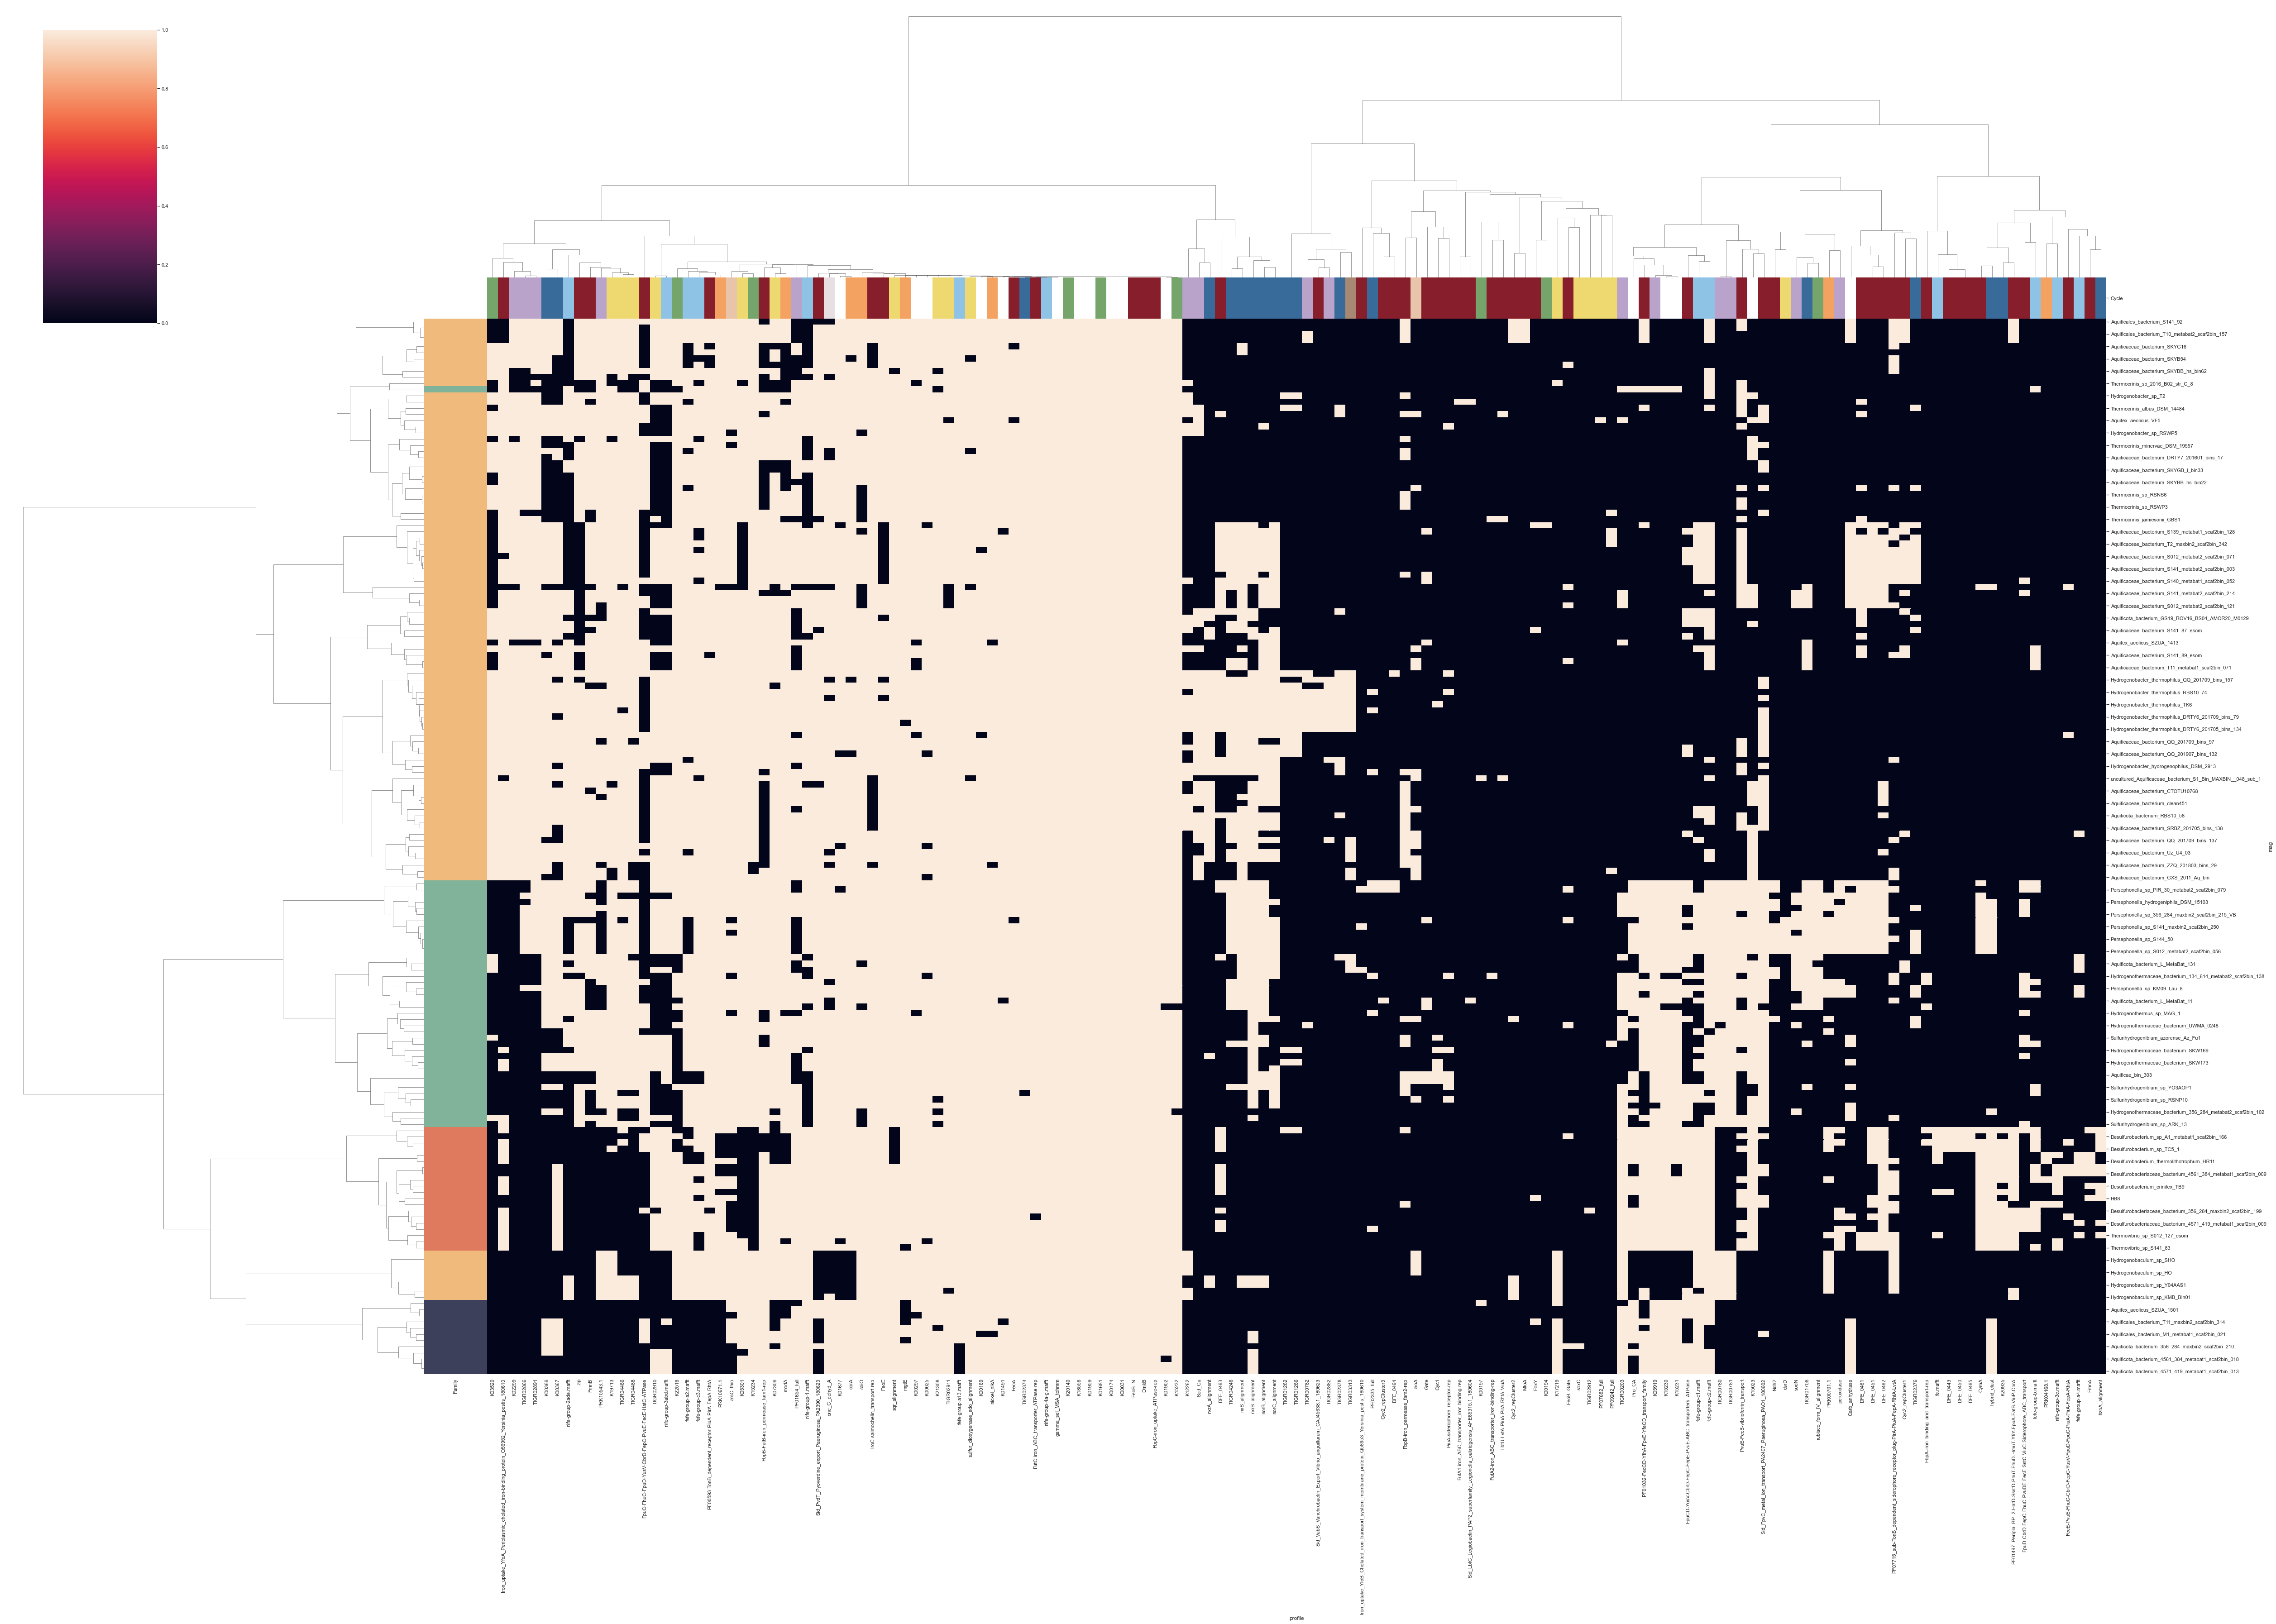

In [74]:
clustermap(
    data=heat_df,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-complete.svg"
    ),
    dpi=300
)

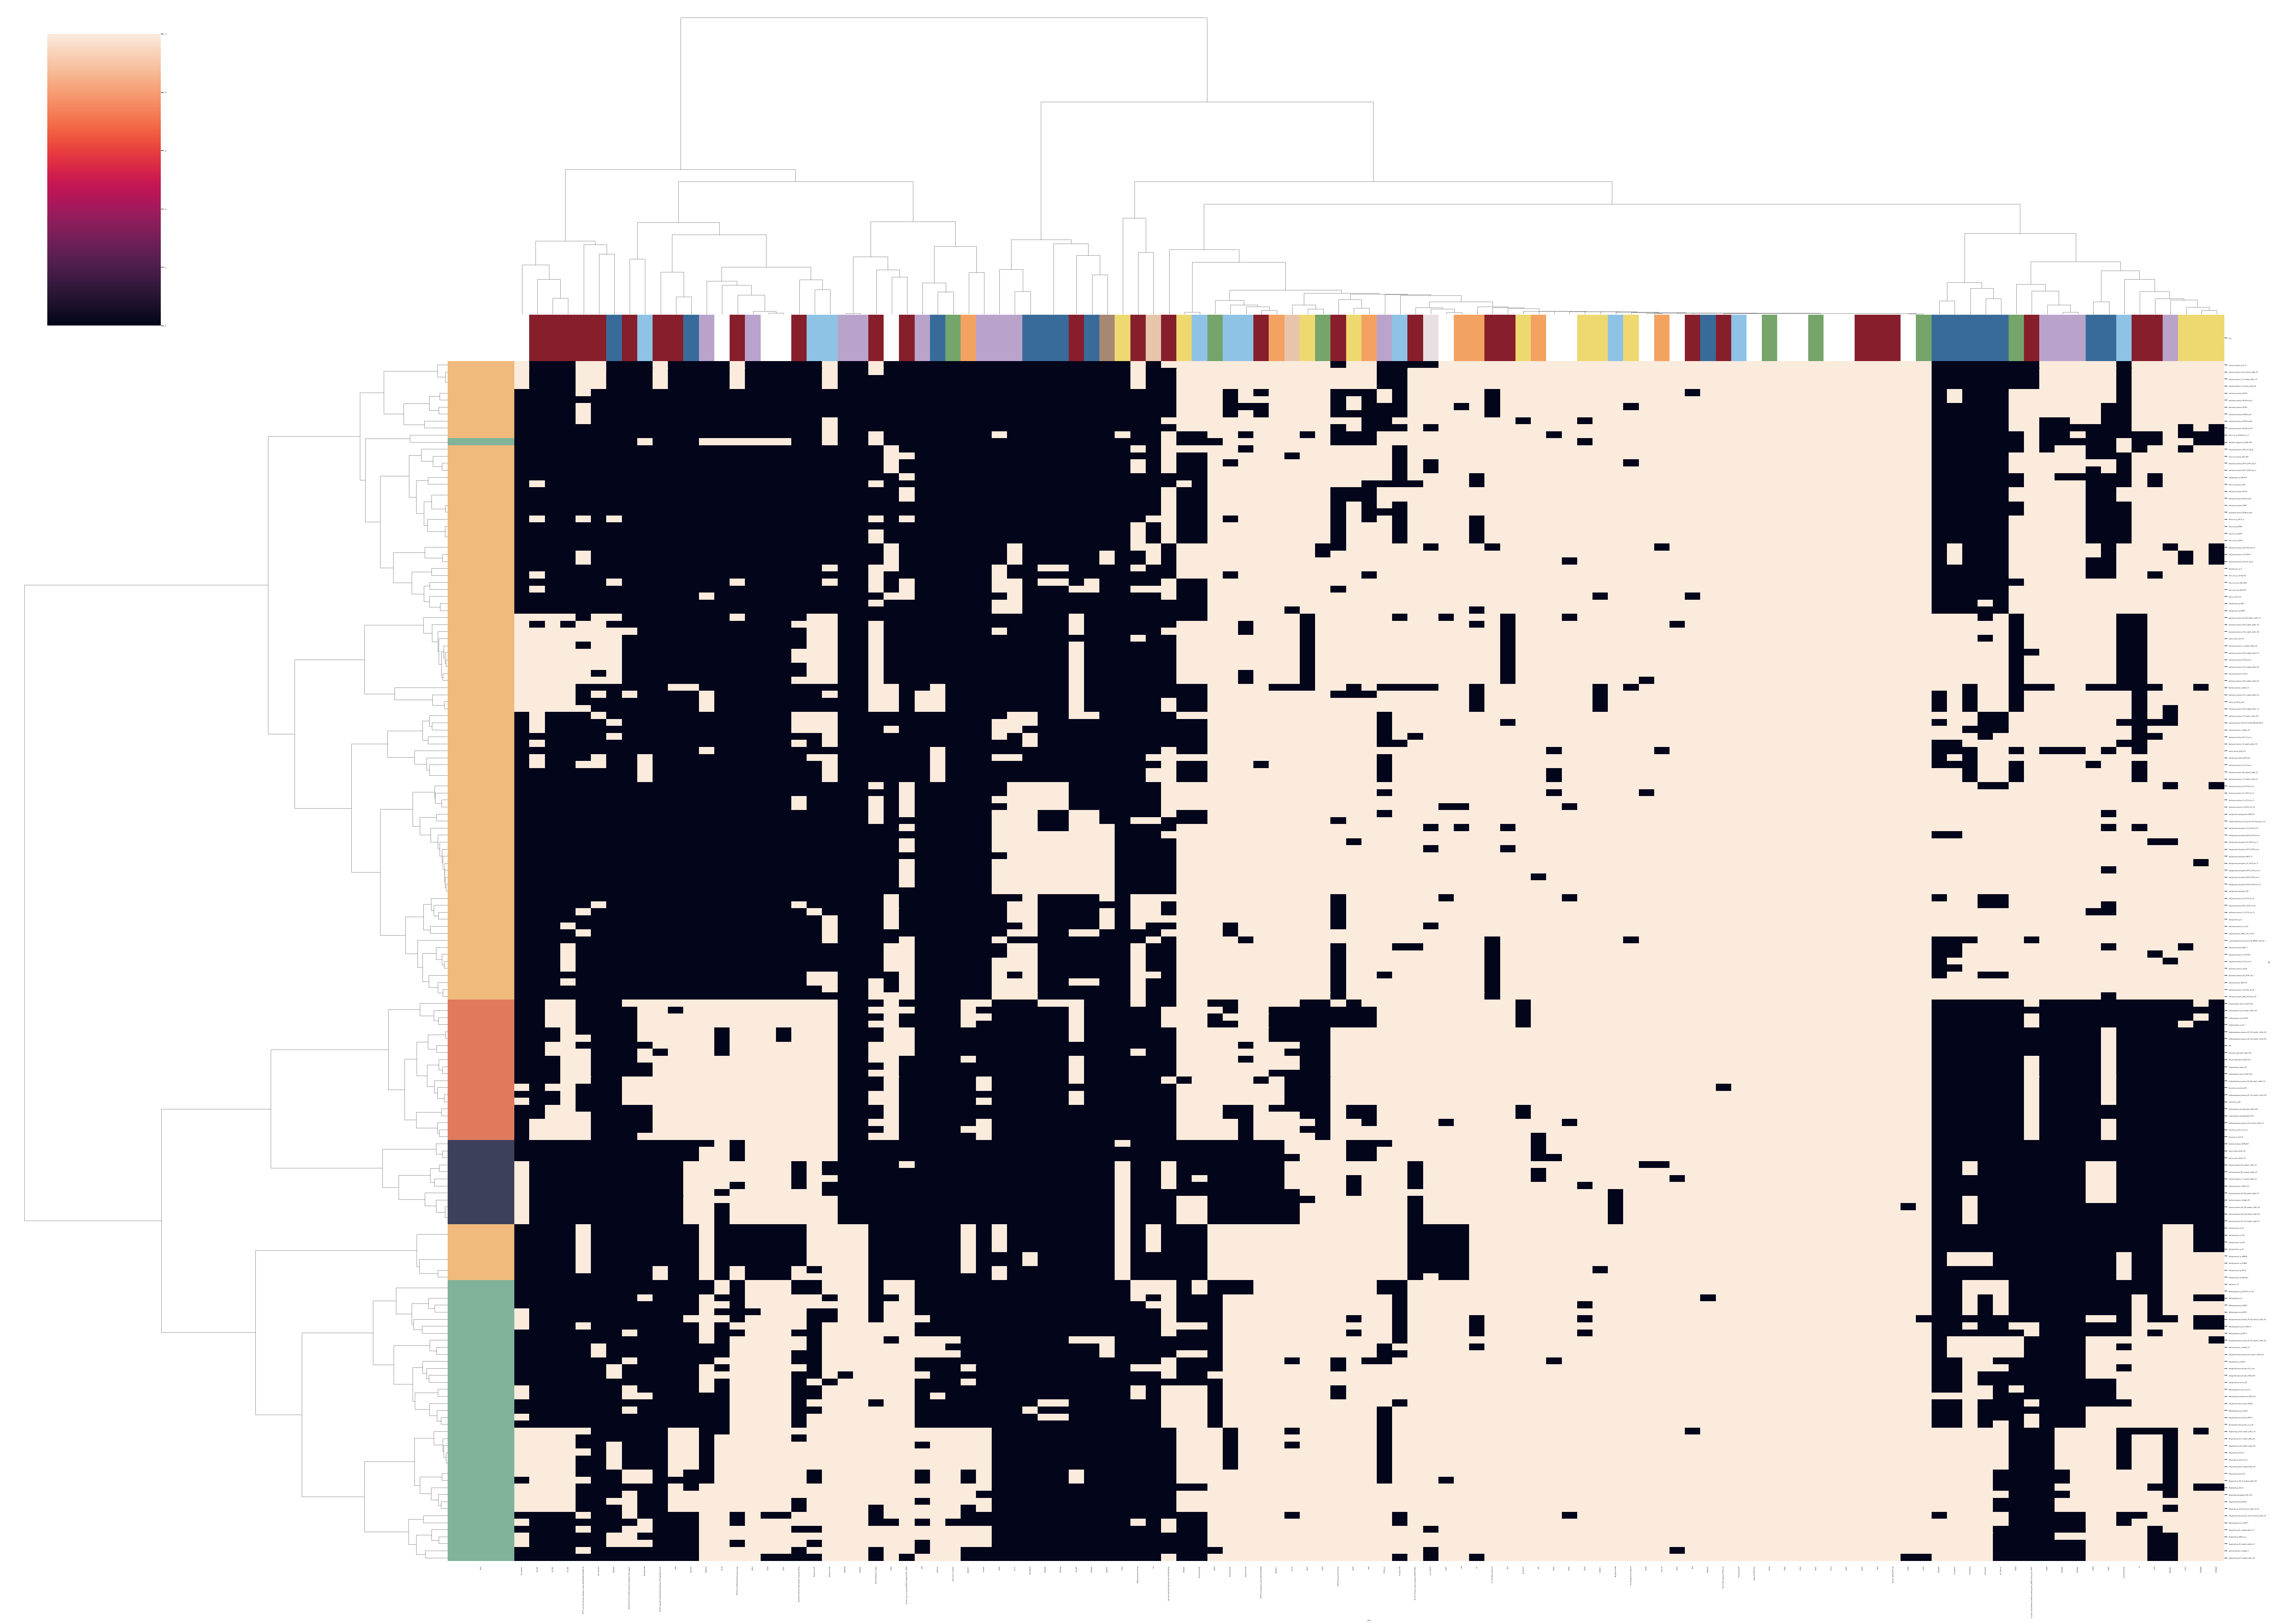

In [65]:
# Select columns that contain less that a proportion of zeroes
non_zero_columns = heat_df.columns[
    (heat_df == 0).mean() <= ABSENCE_THR
]
heat_df_nonzero = heat_df[non_zero_columns]

clustermap(
    data=heat_df_nonzero,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-nonzero.svg"
    ),
    dpi=300
)

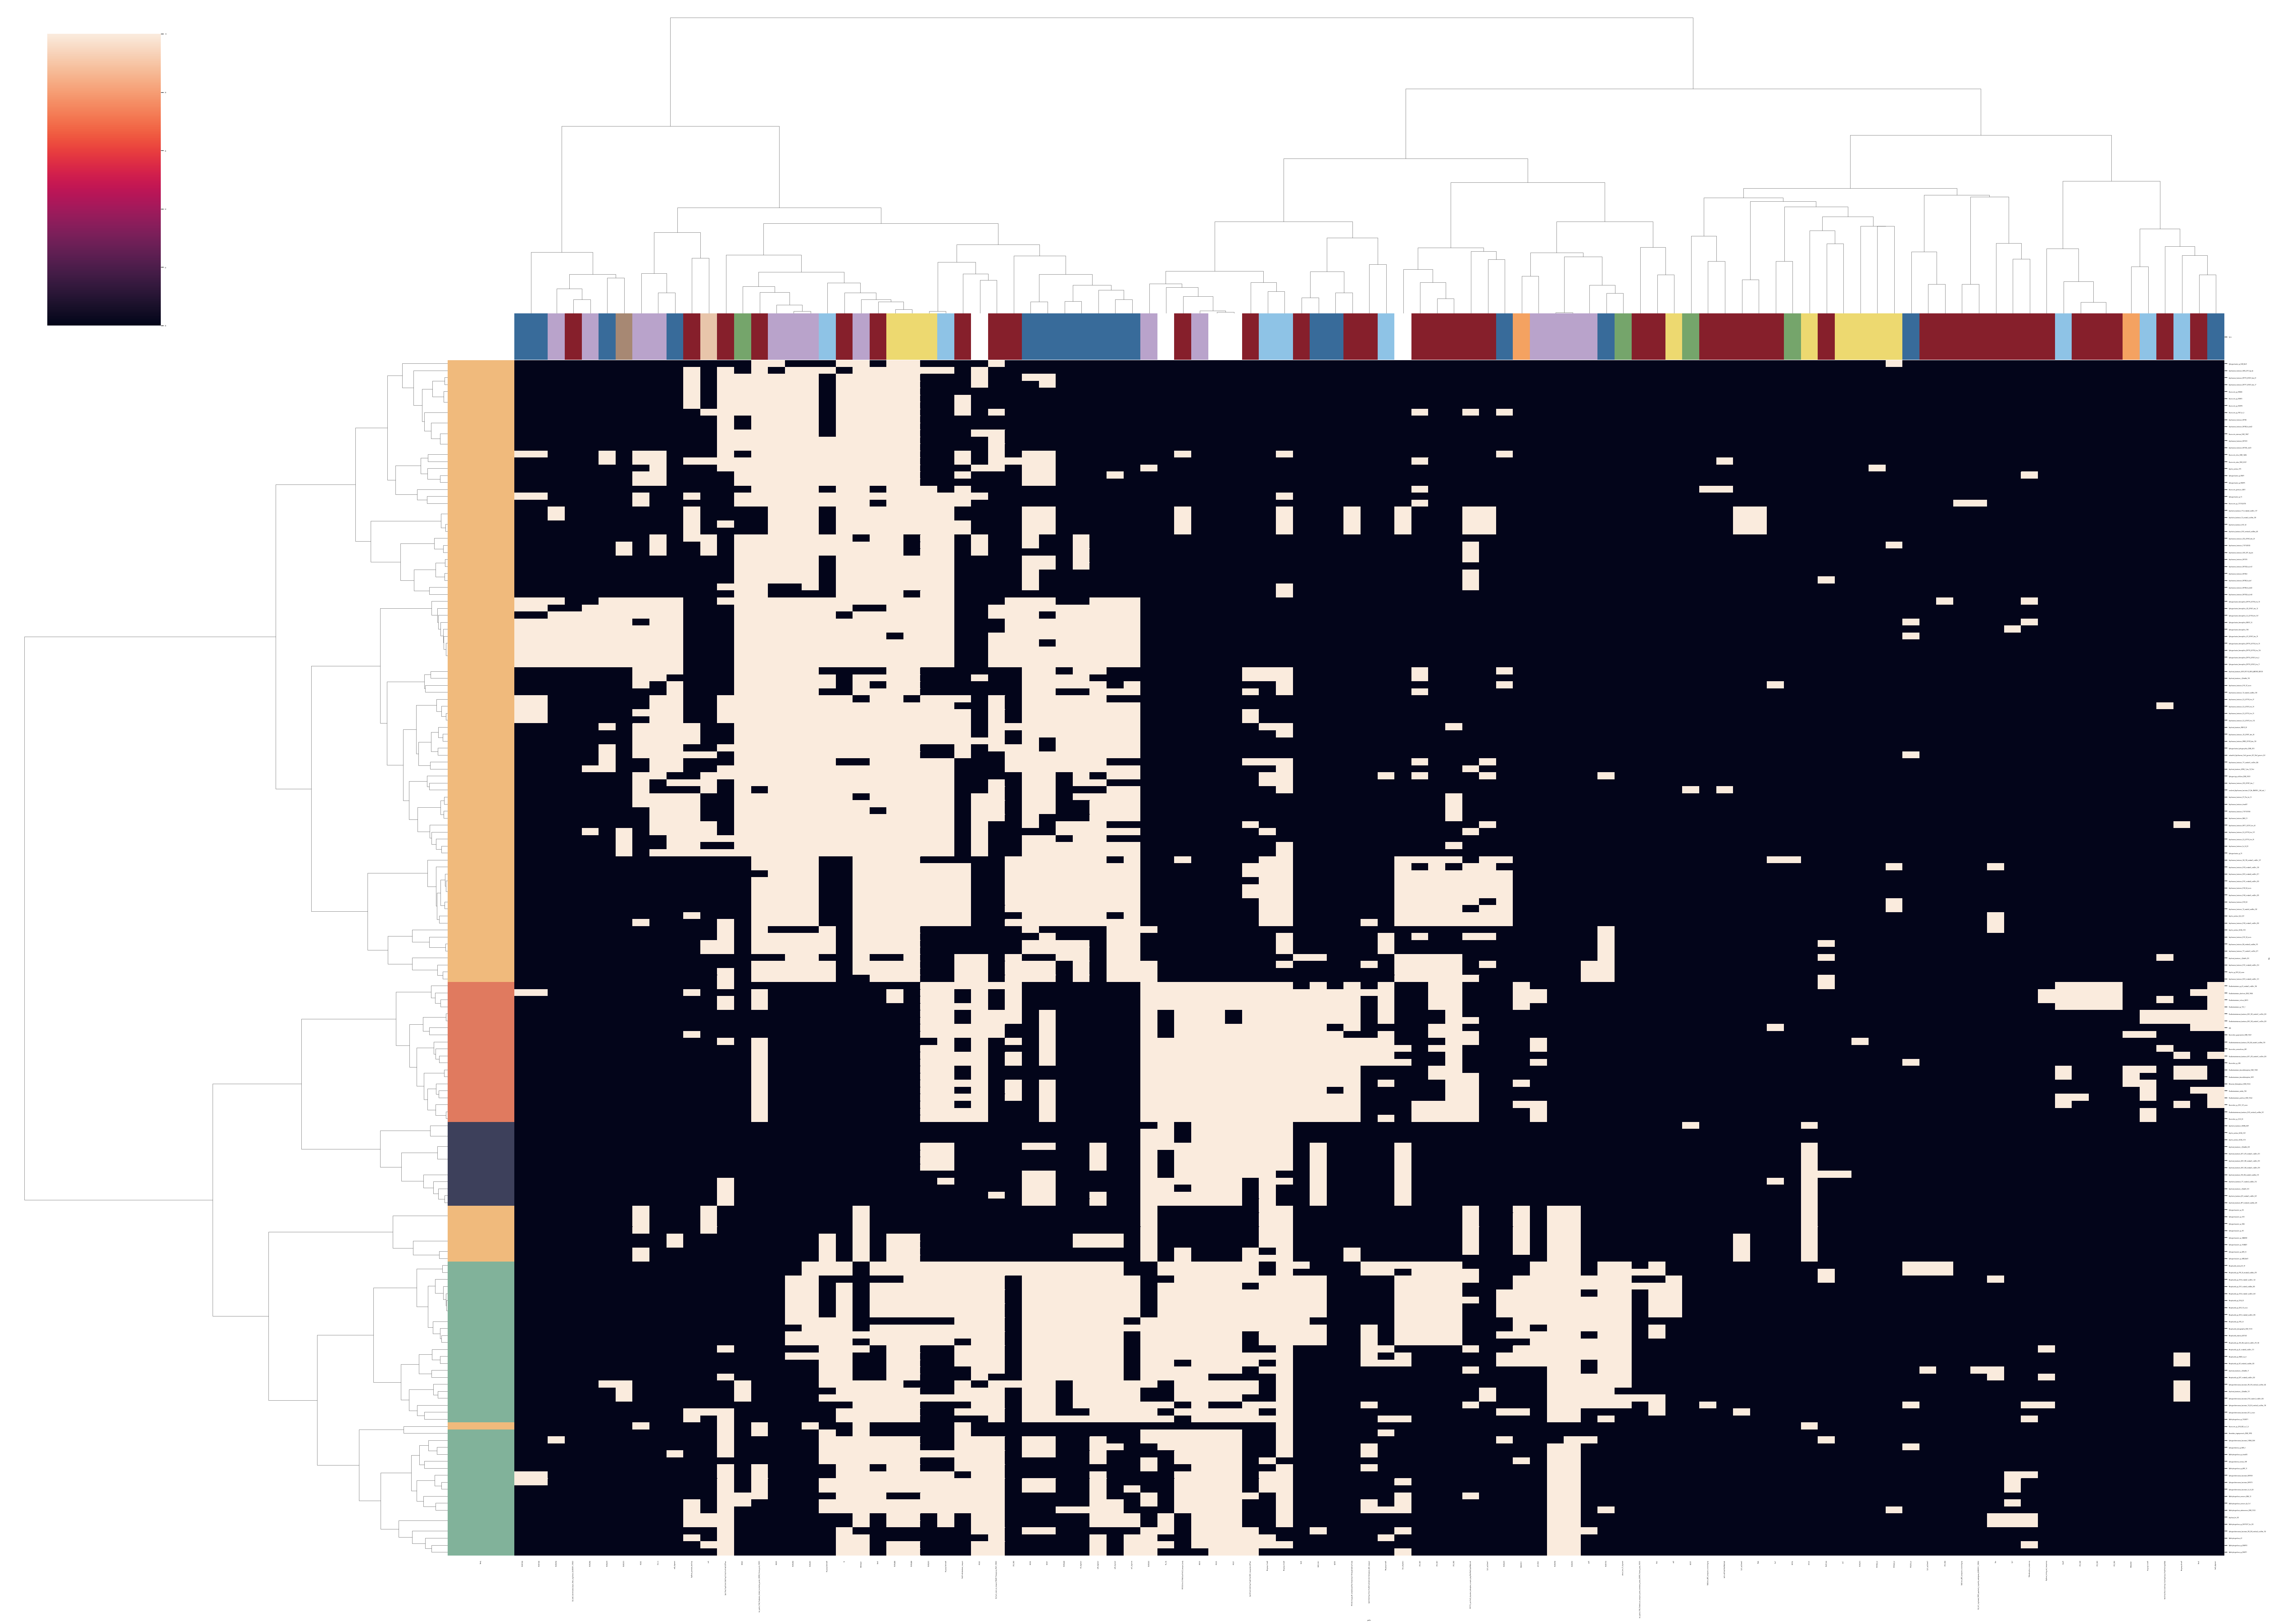

In [67]:
clustermap(
    data=heat_df.drop(core_hmms, axis=1),
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-accessory.svg"
    ),
    dpi=300
)

## Cycles clustermaps

[+] Clustermap for cycle Arsenic
[ERROR] Could not create clustermap for cycle Arsenic: NaN dissimilarity value.
[+] Clustermap for cycle Carbon


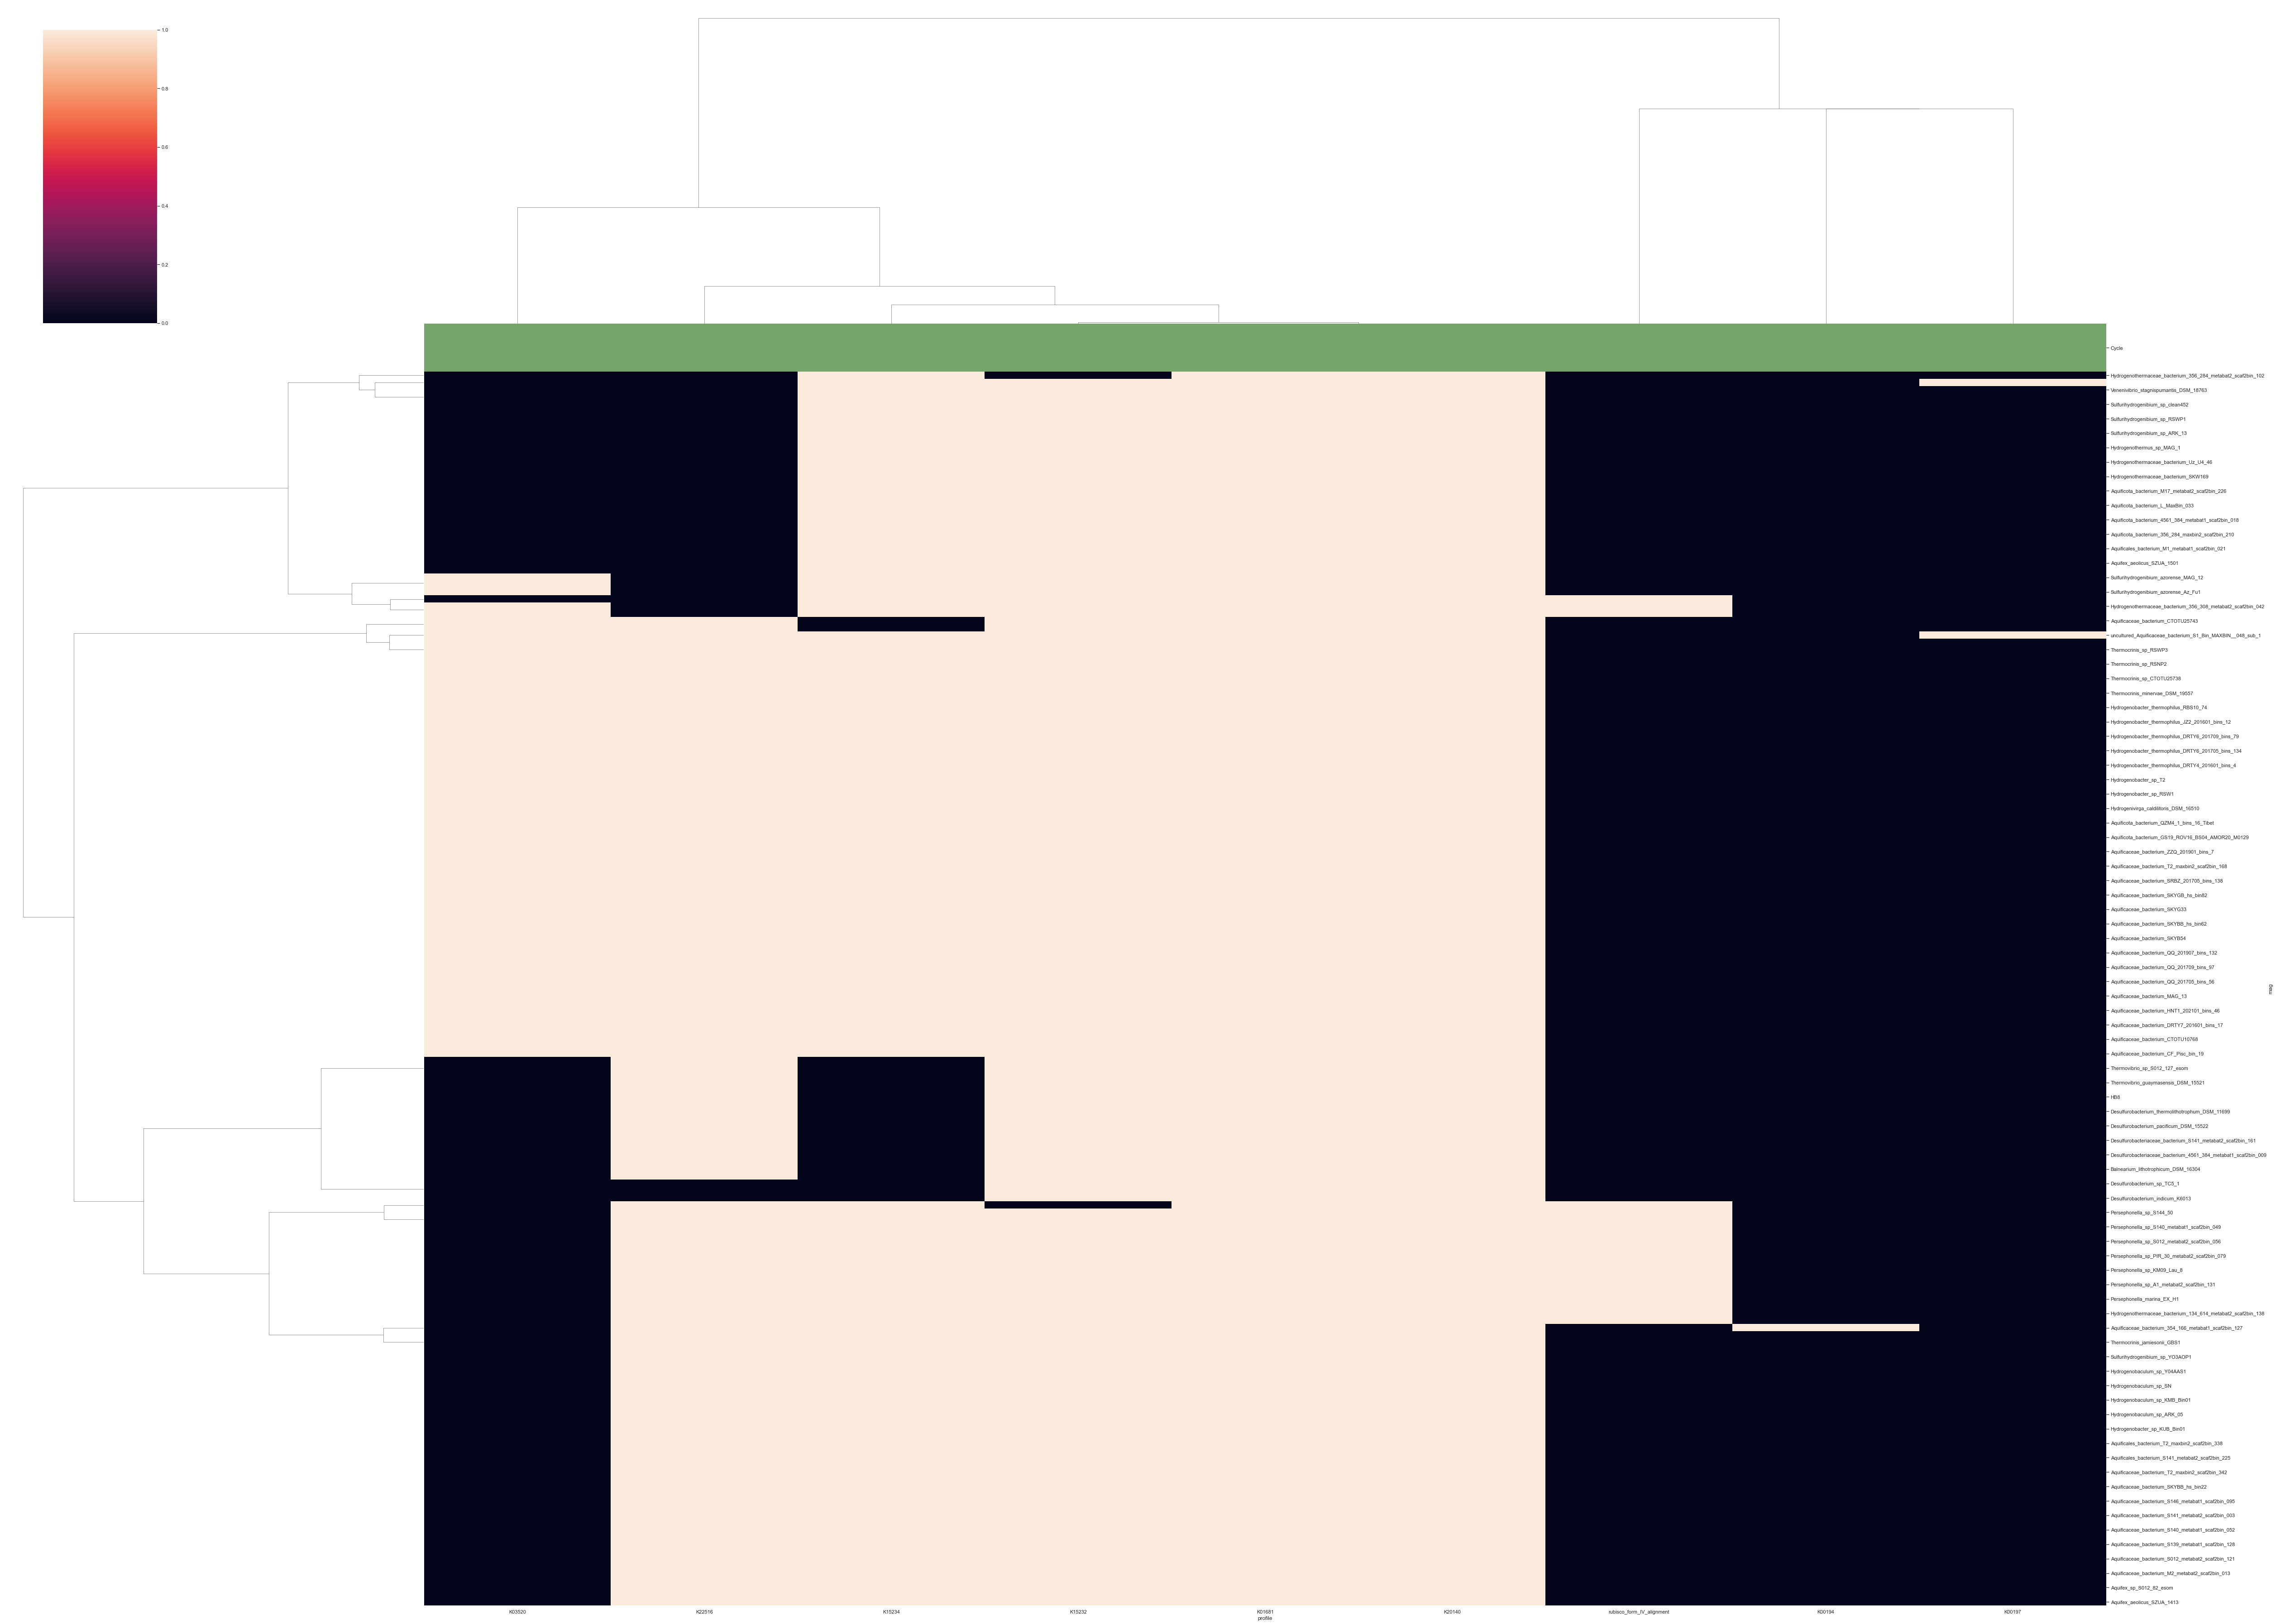

[+] Clustermap for cycle Methane
[ERROR] Could not create clustermap for cycle Methane: NaN dissimilarity value.
[+] Clustermap for cycle Nitrogen


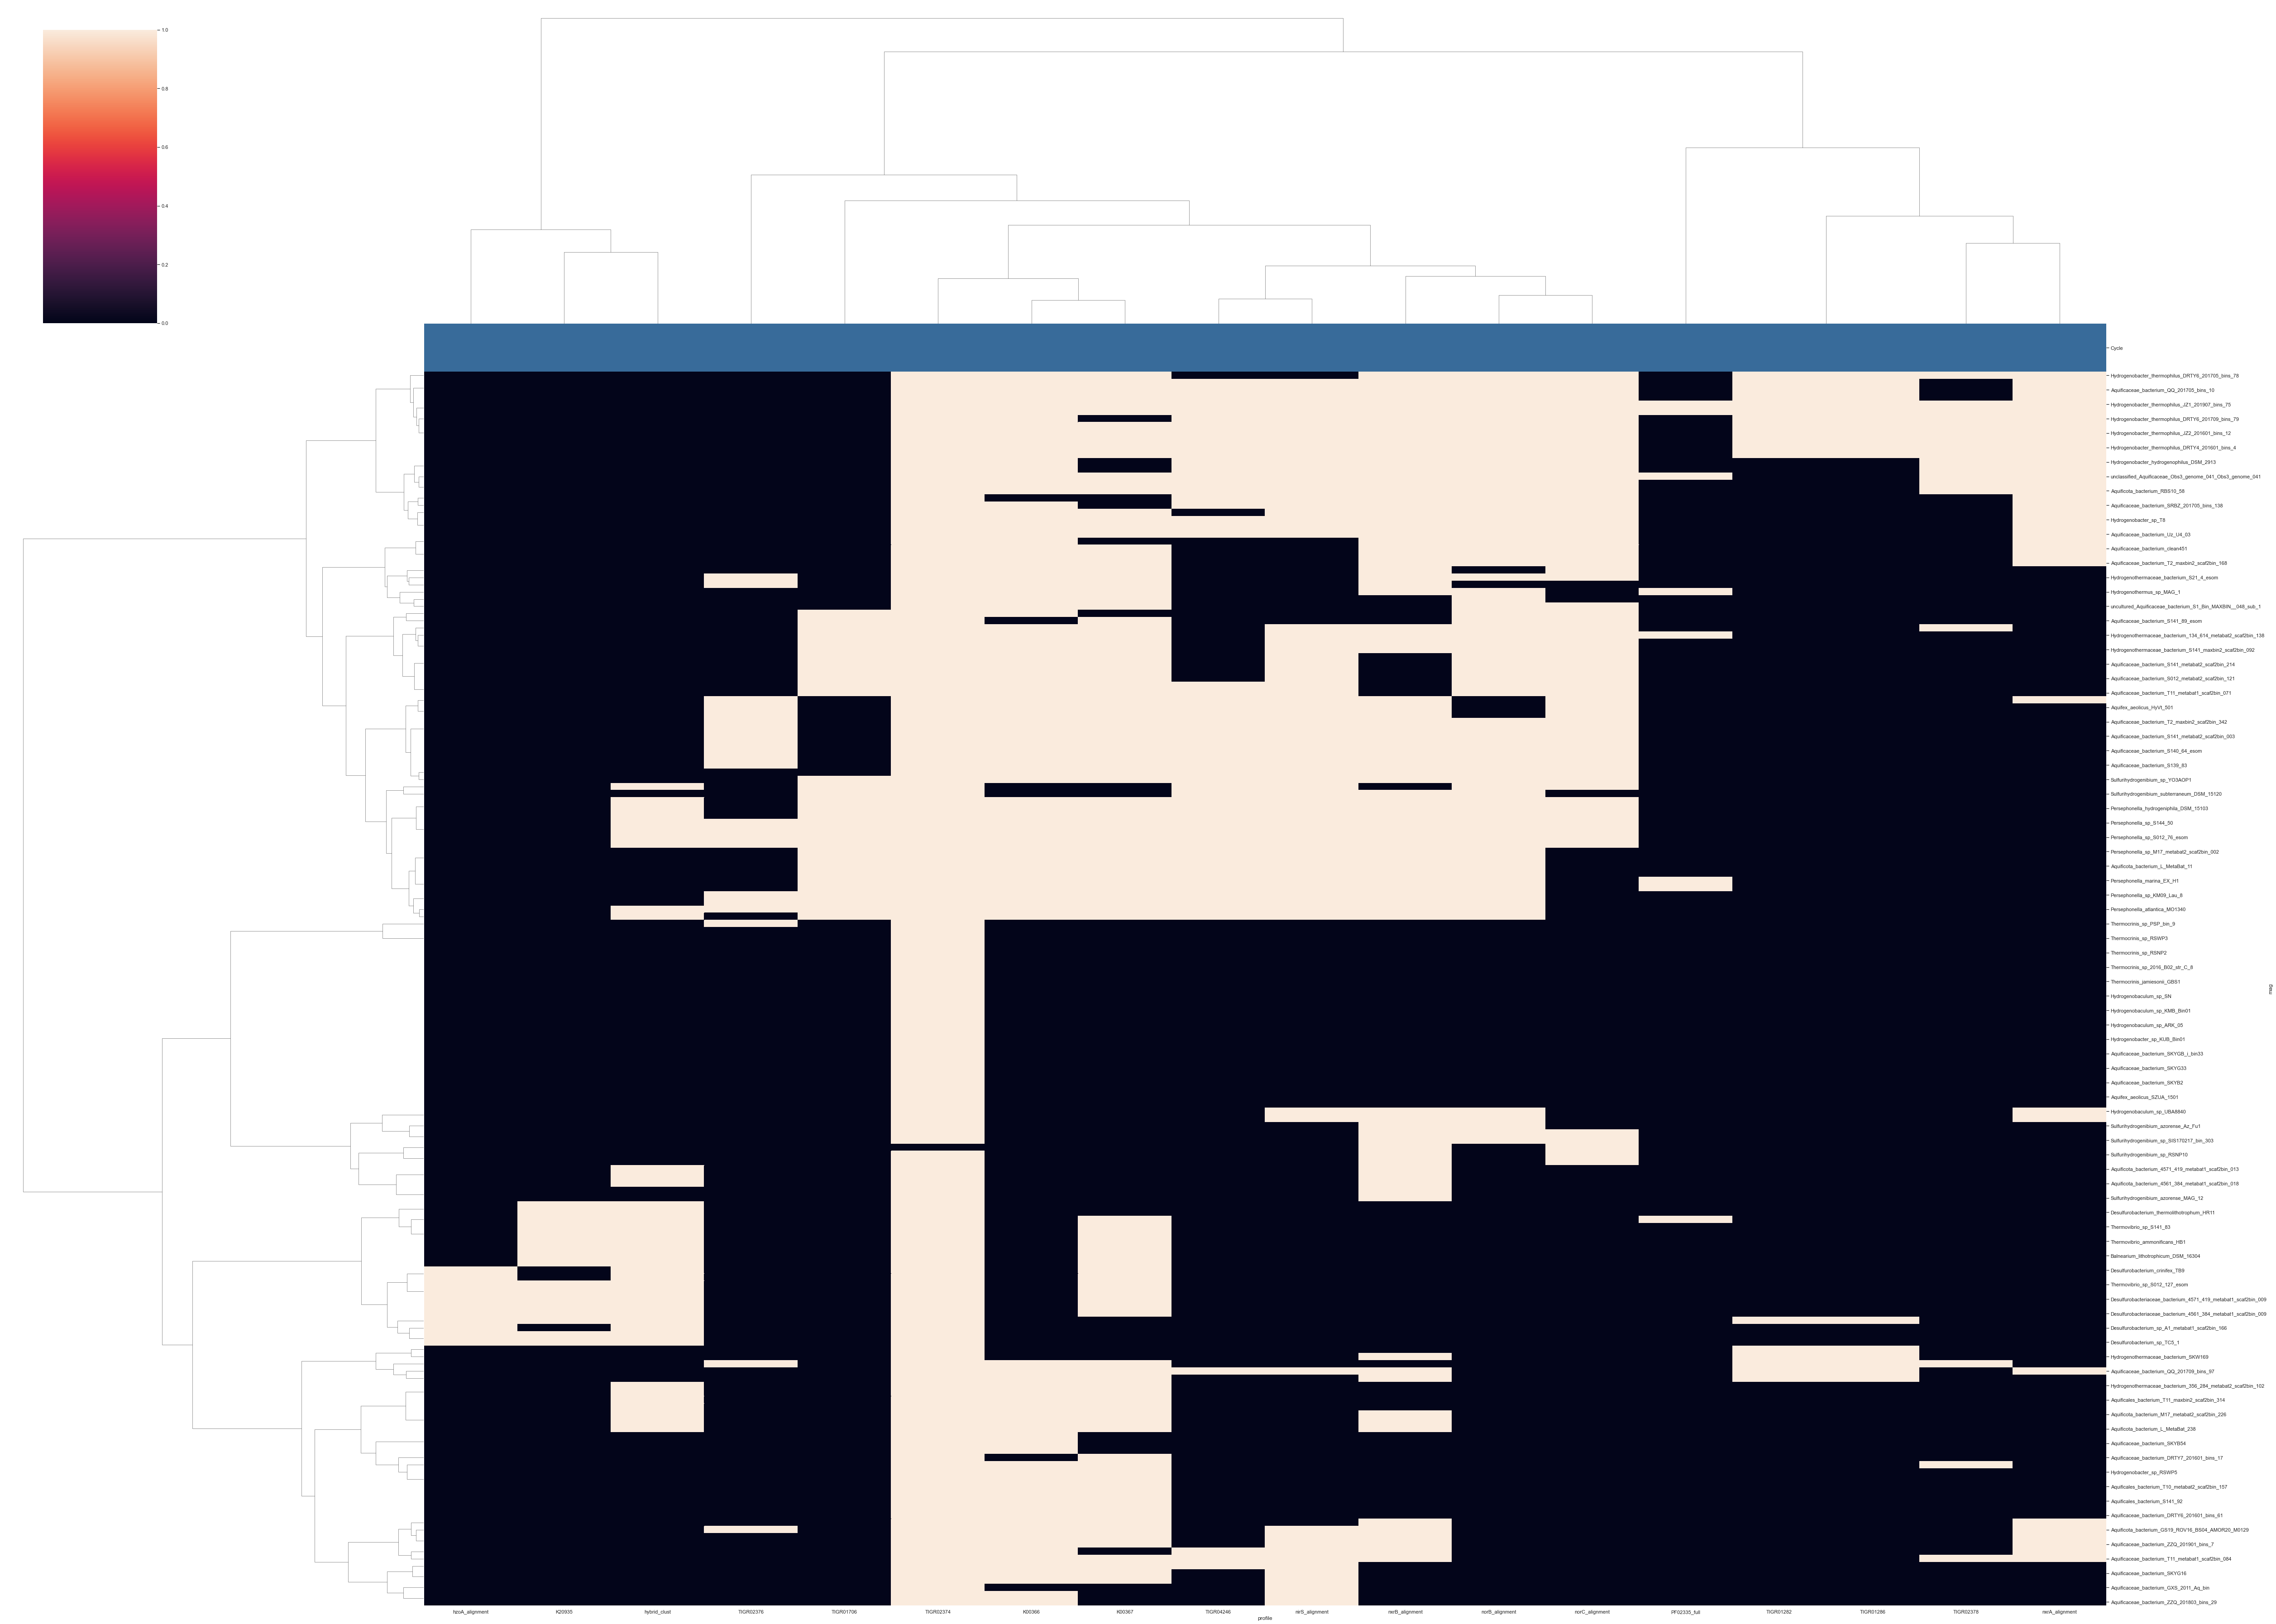

[+] Clustermap for cycle Oxygen


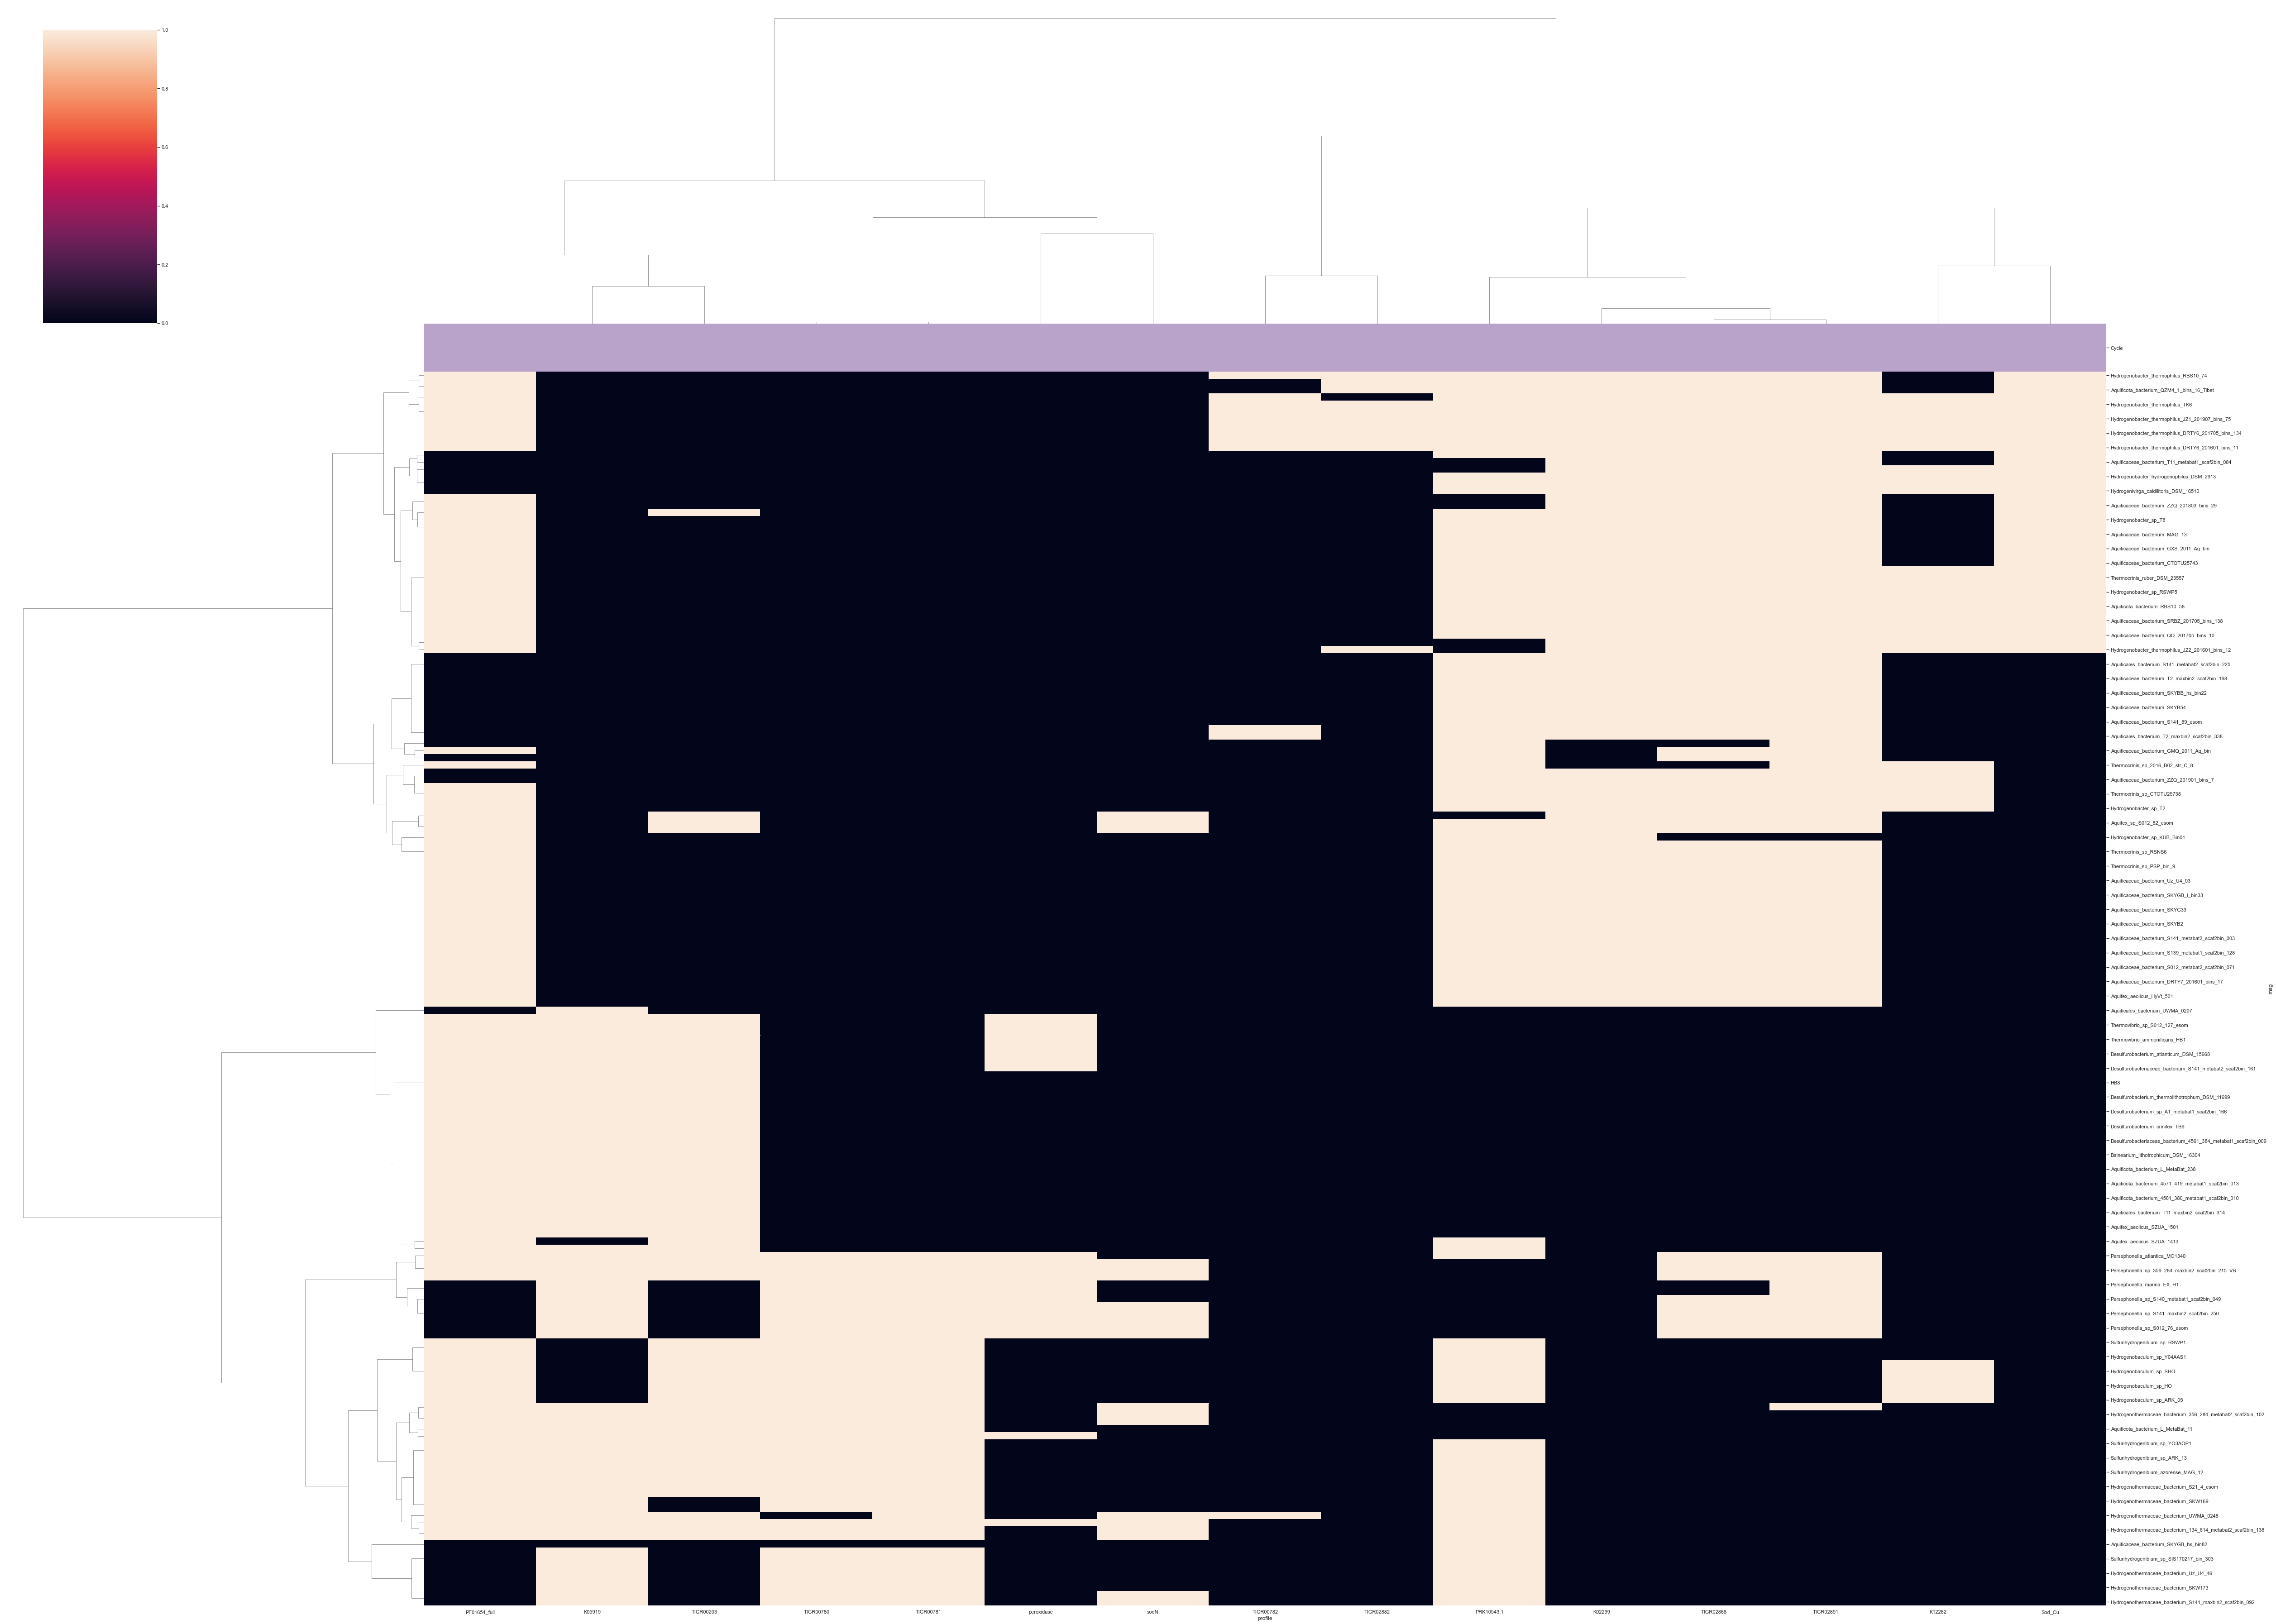

[+] Clustermap for cycle Photosynthesis
[ERROR] Could not create clustermap for cycle Photosynthesis: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Sulfur


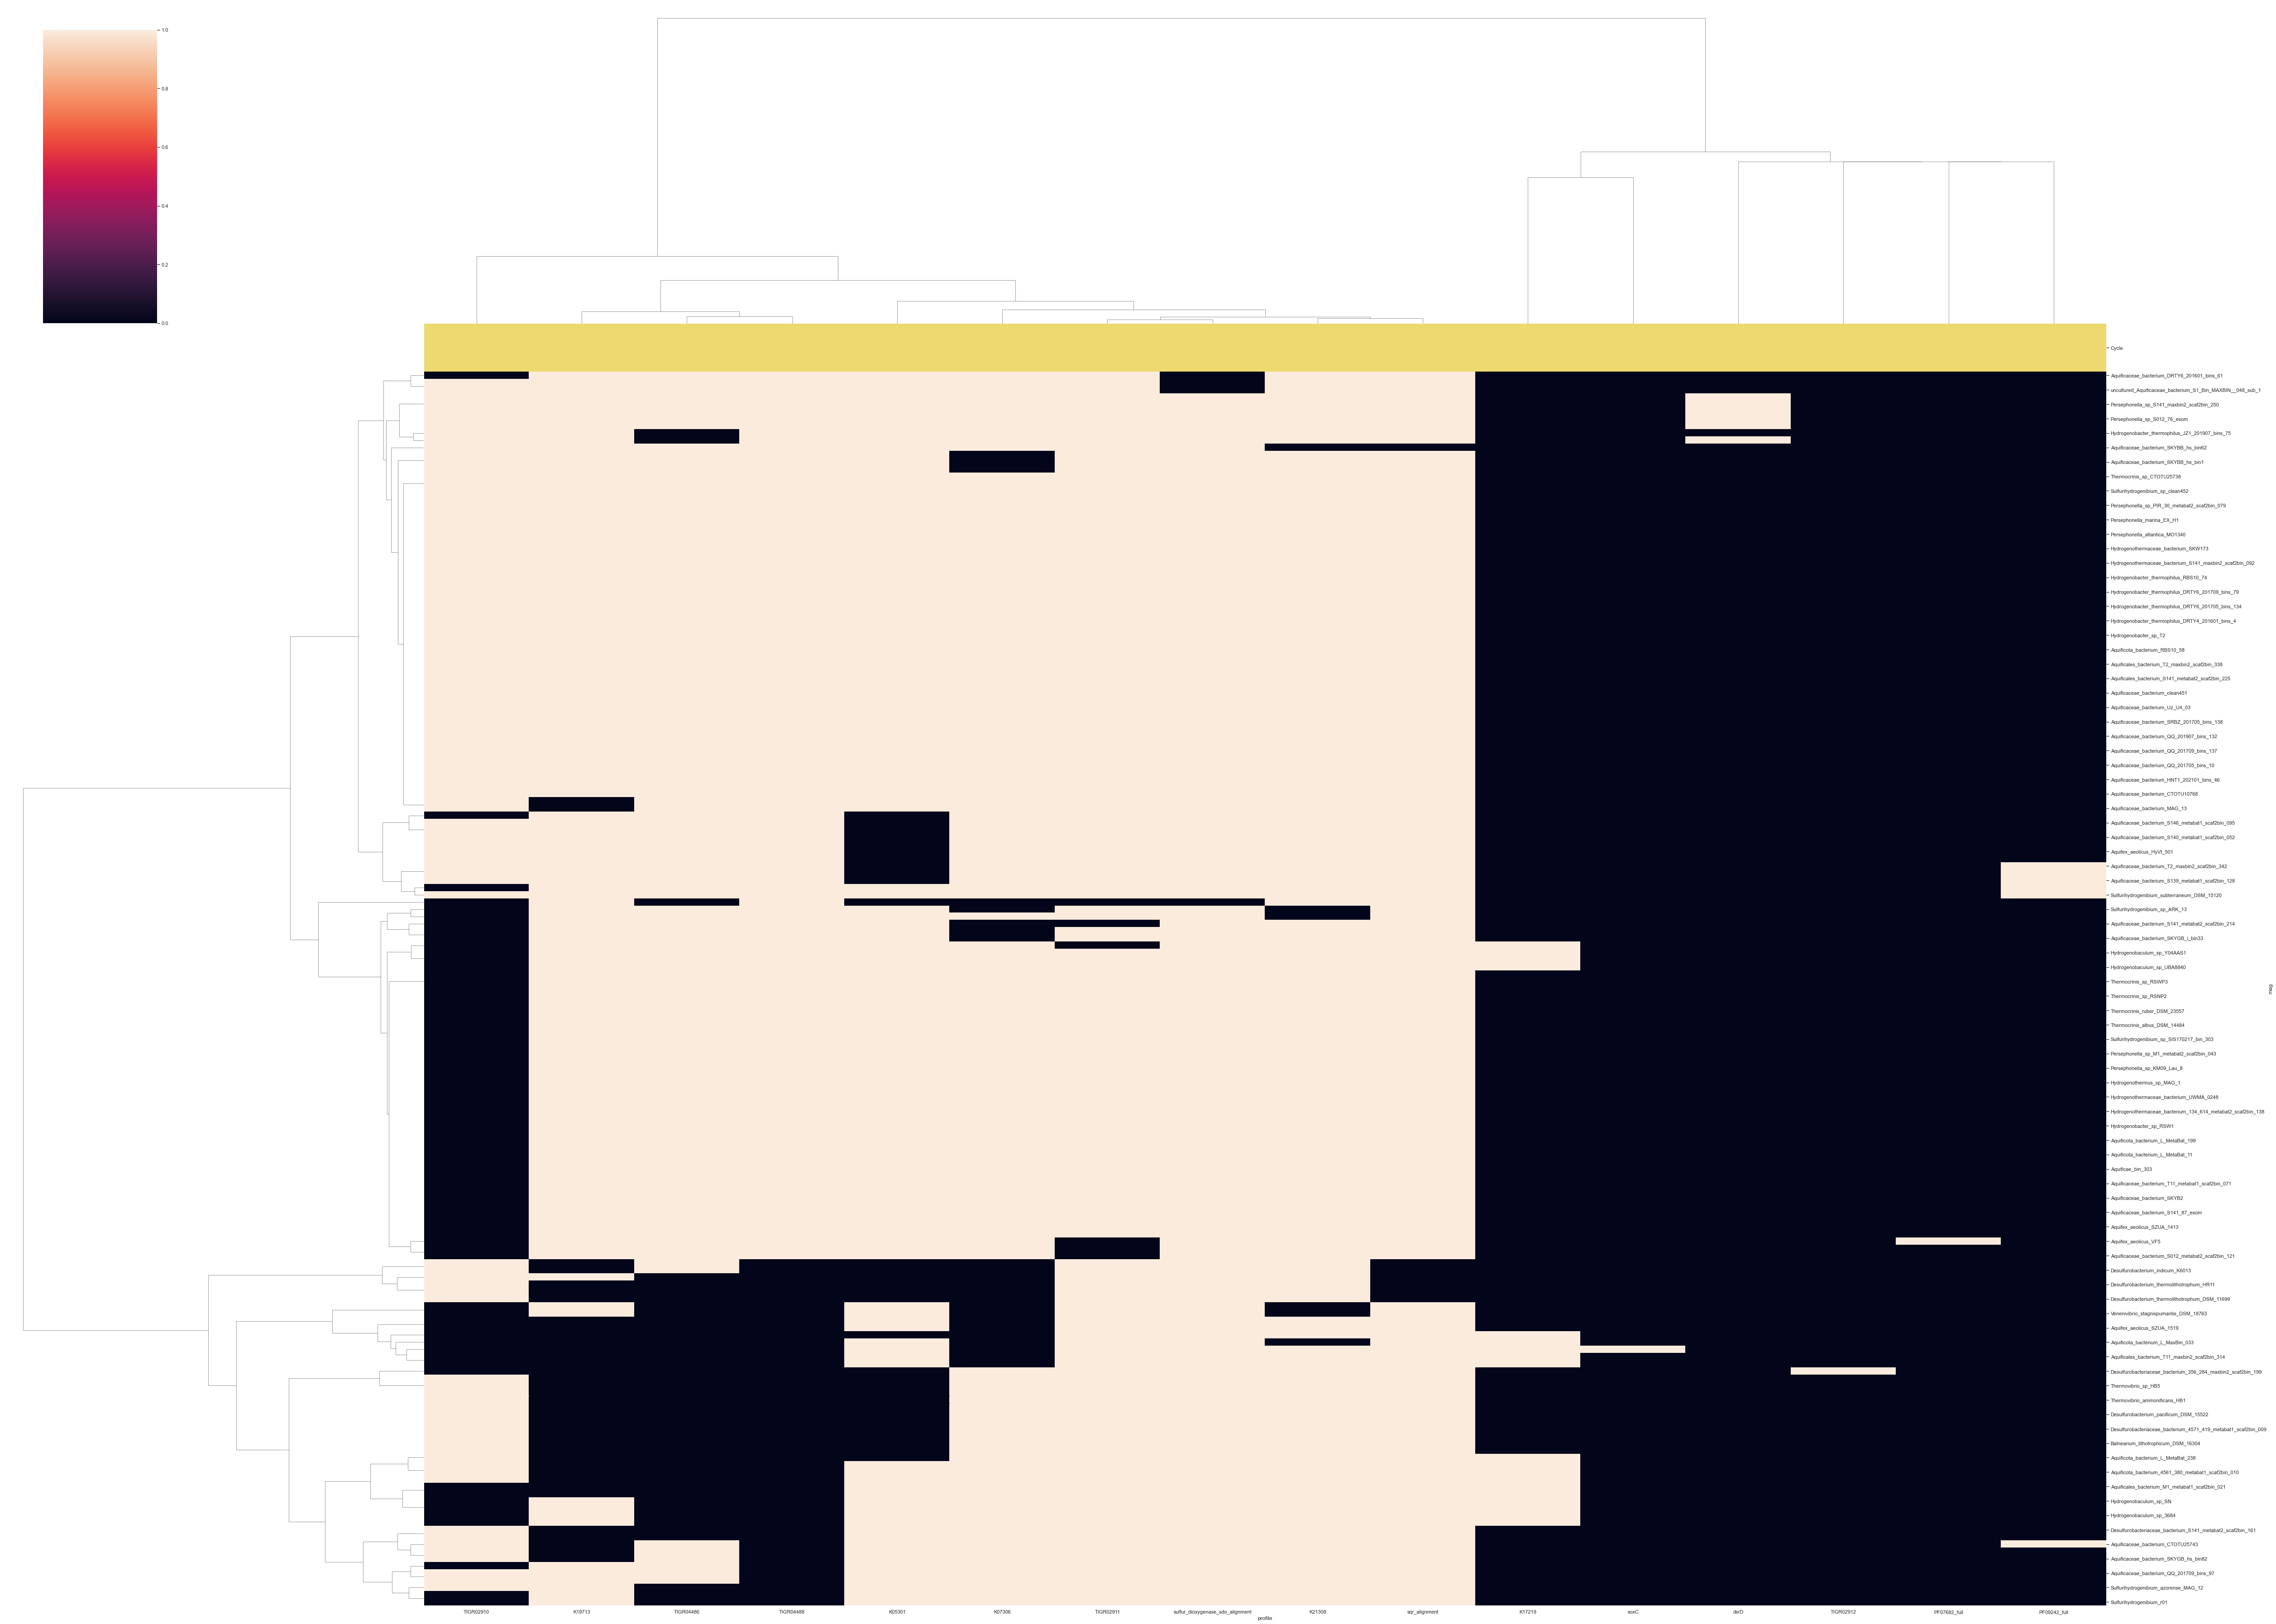

[+] Clustermap for cycle Transporters


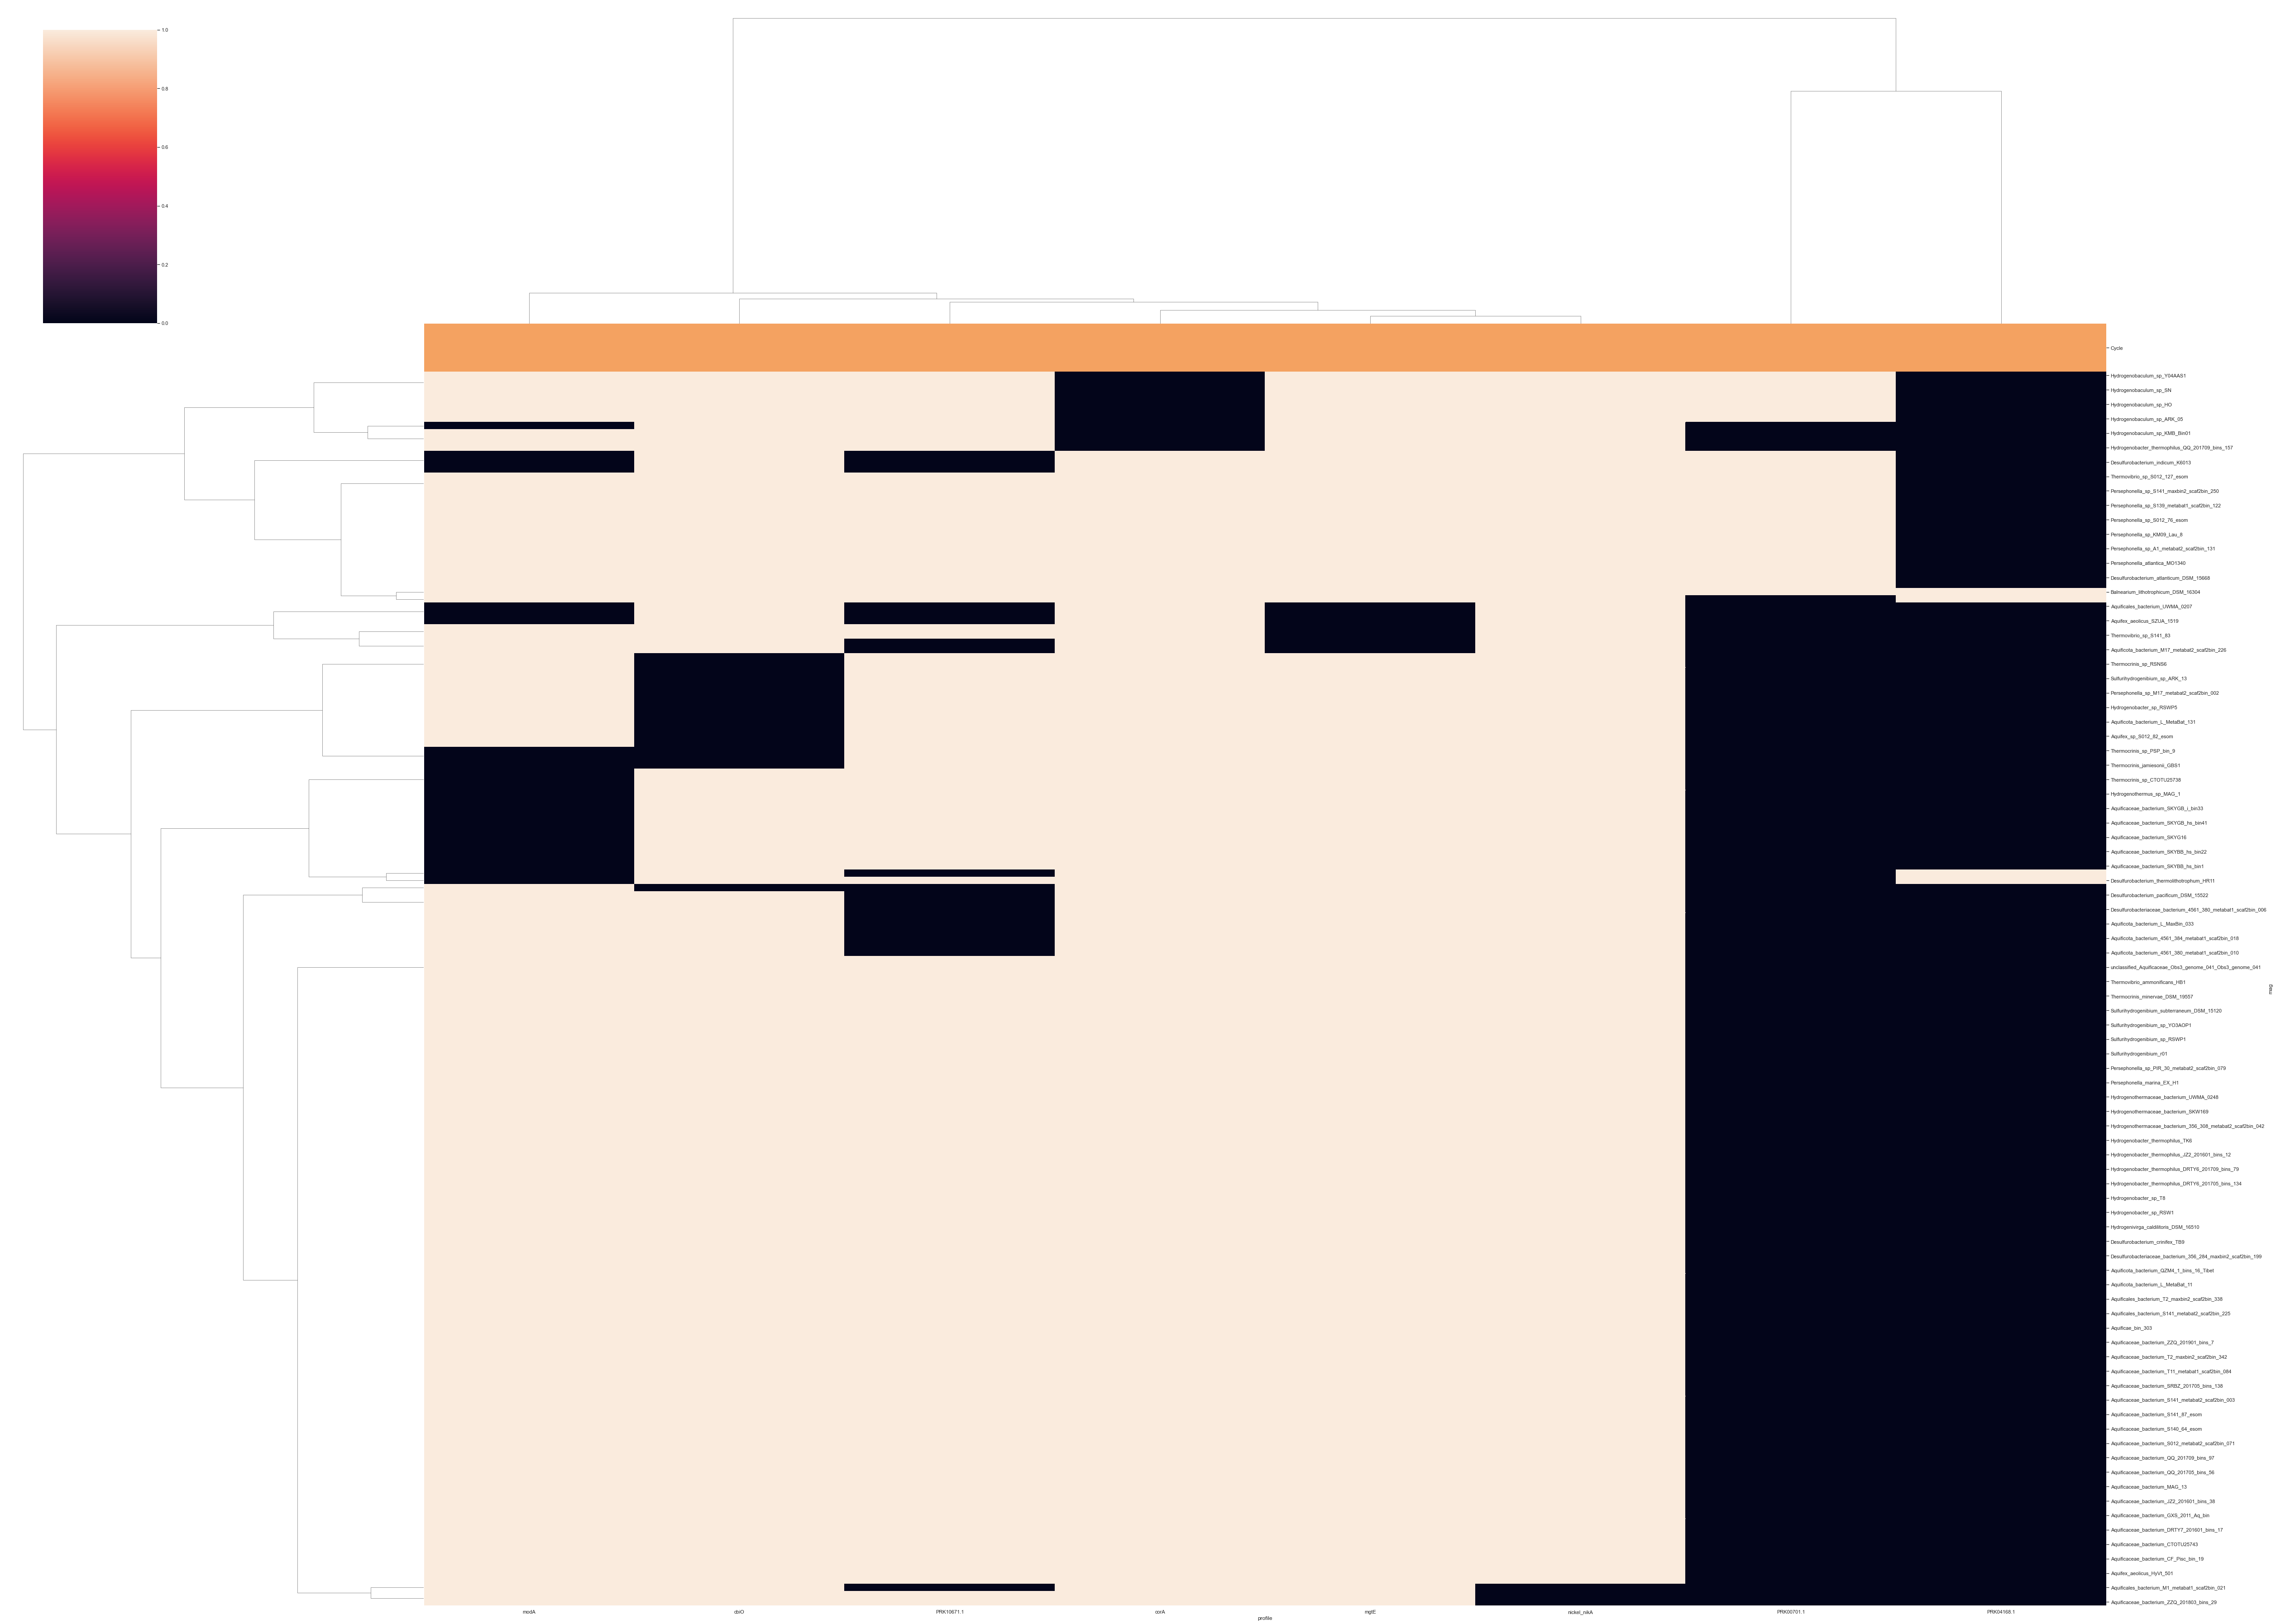

[+] Clustermap for cycle Hydrogen


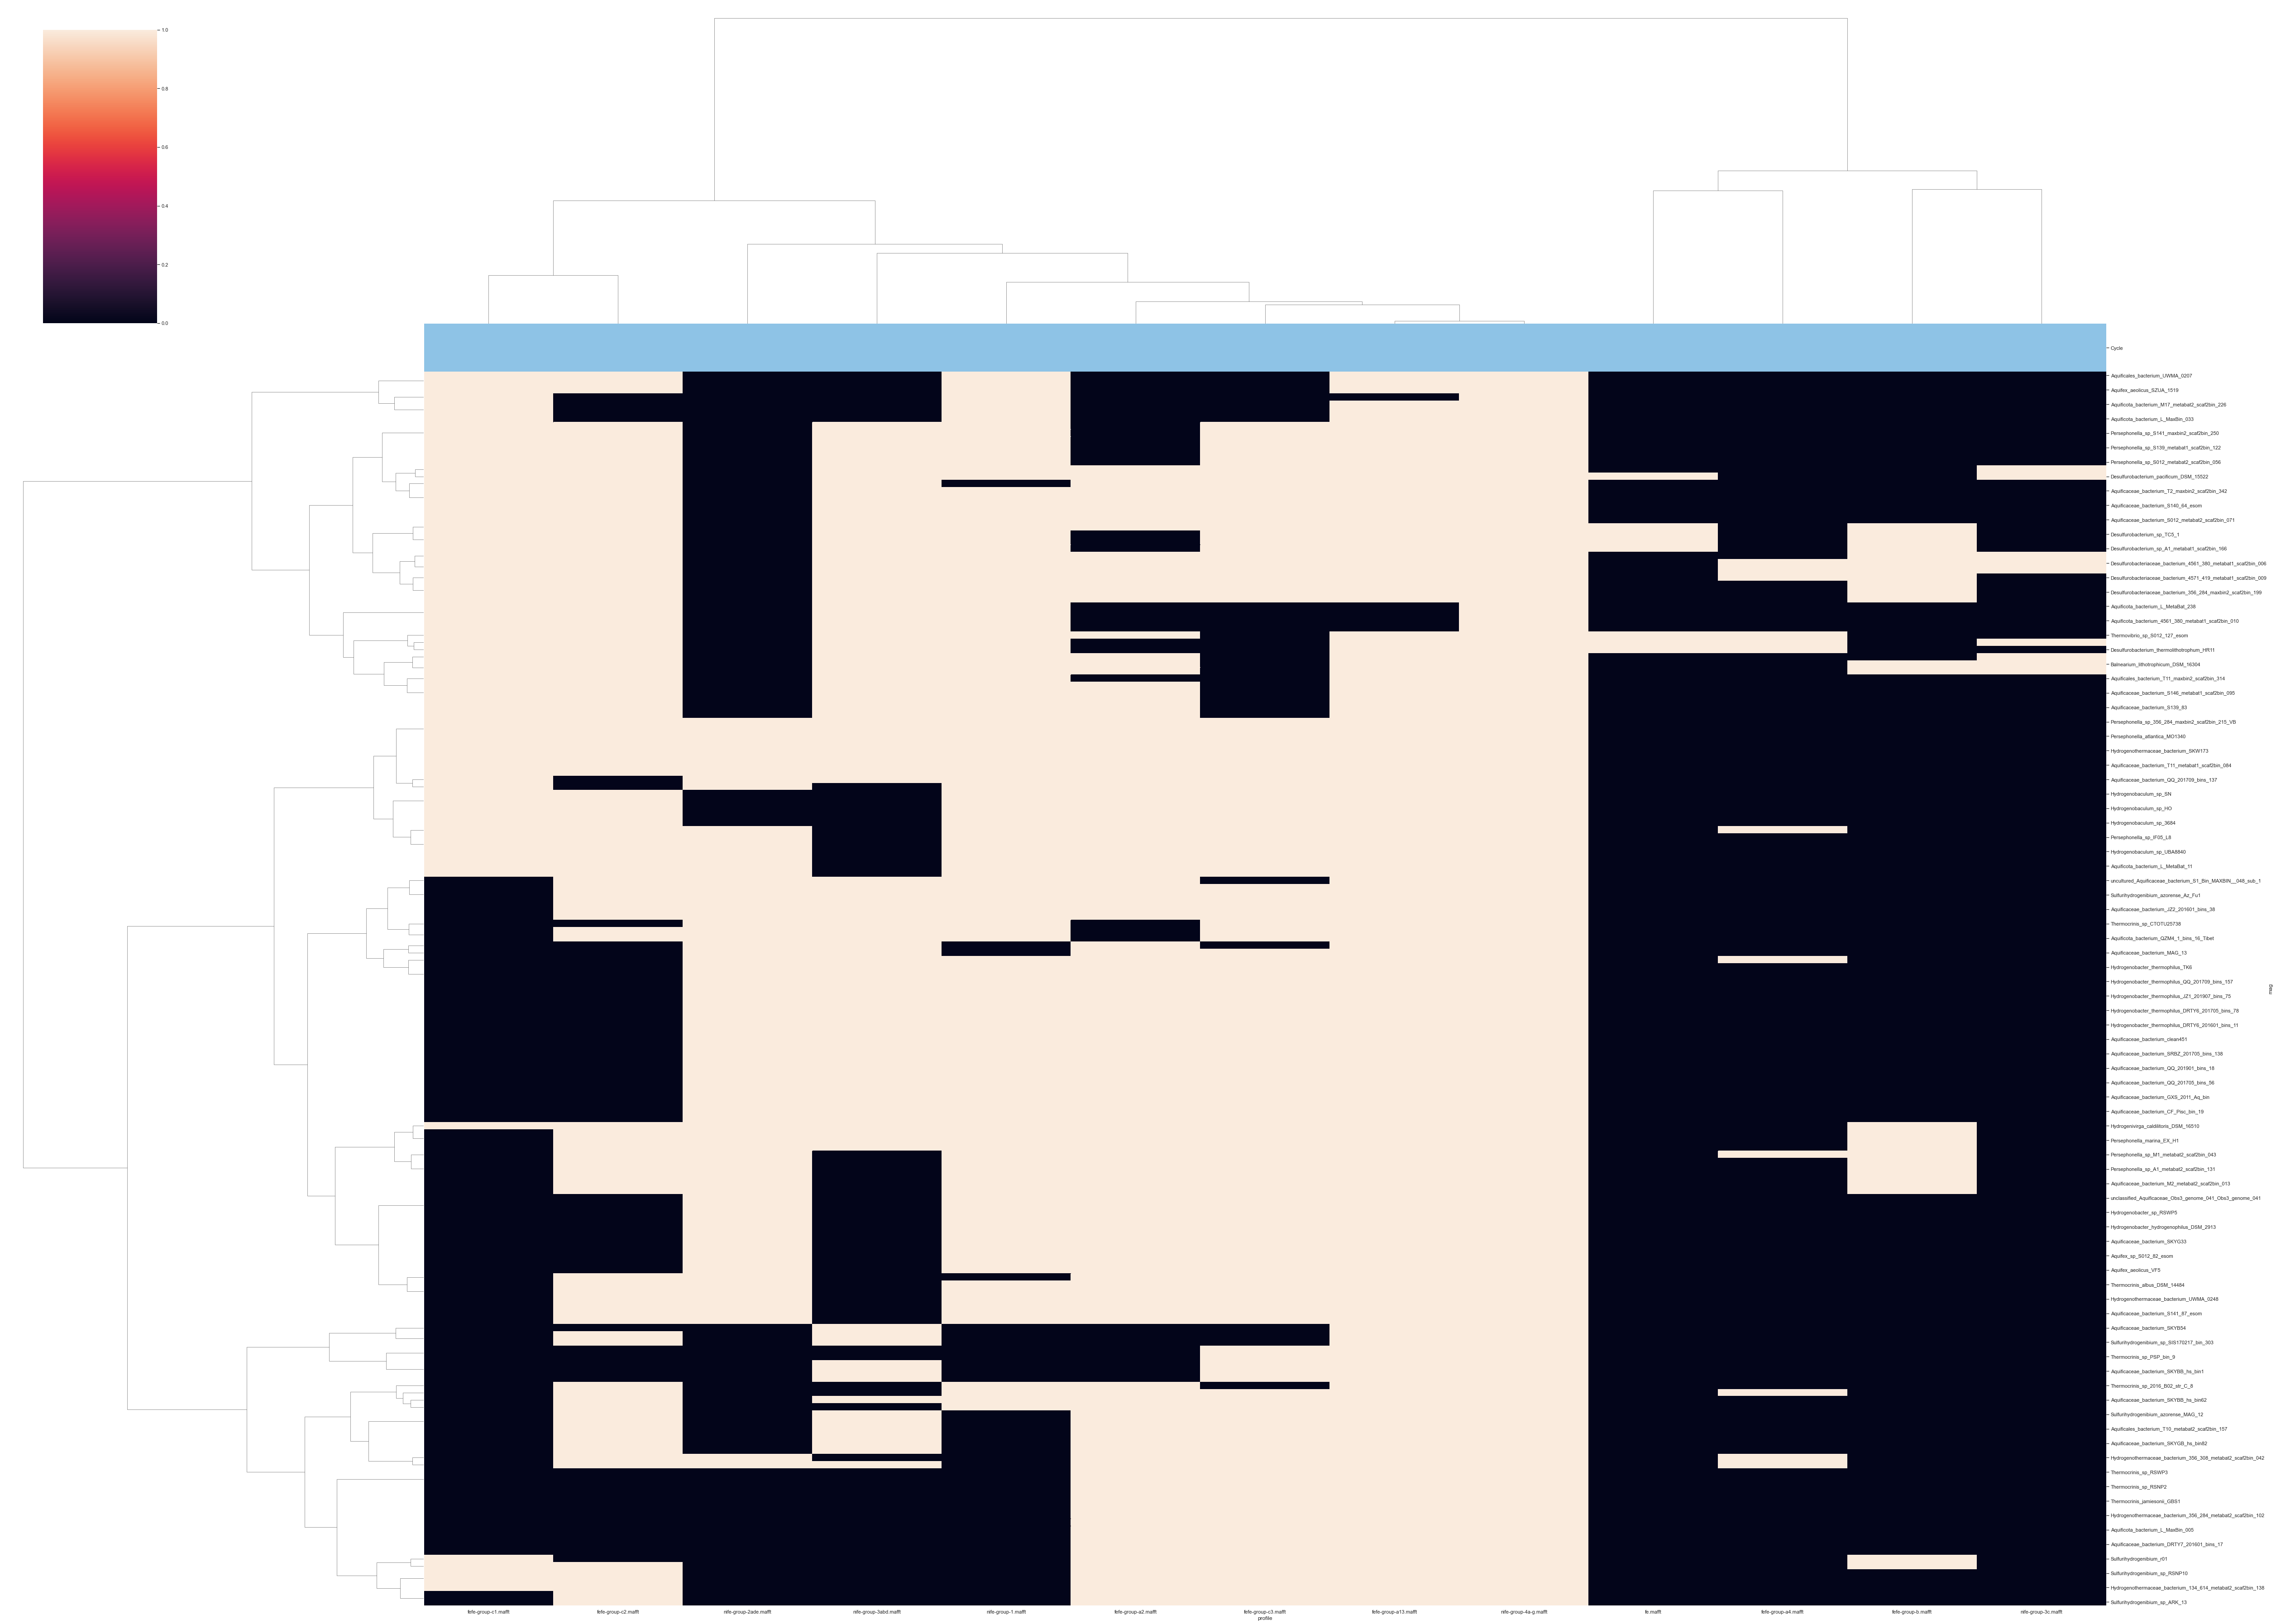

[+] Clustermap for cycle Selenium
[ERROR] Could not create clustermap for cycle Selenium: NaN dissimilarity value.
[+] Clustermap for cycle Iron


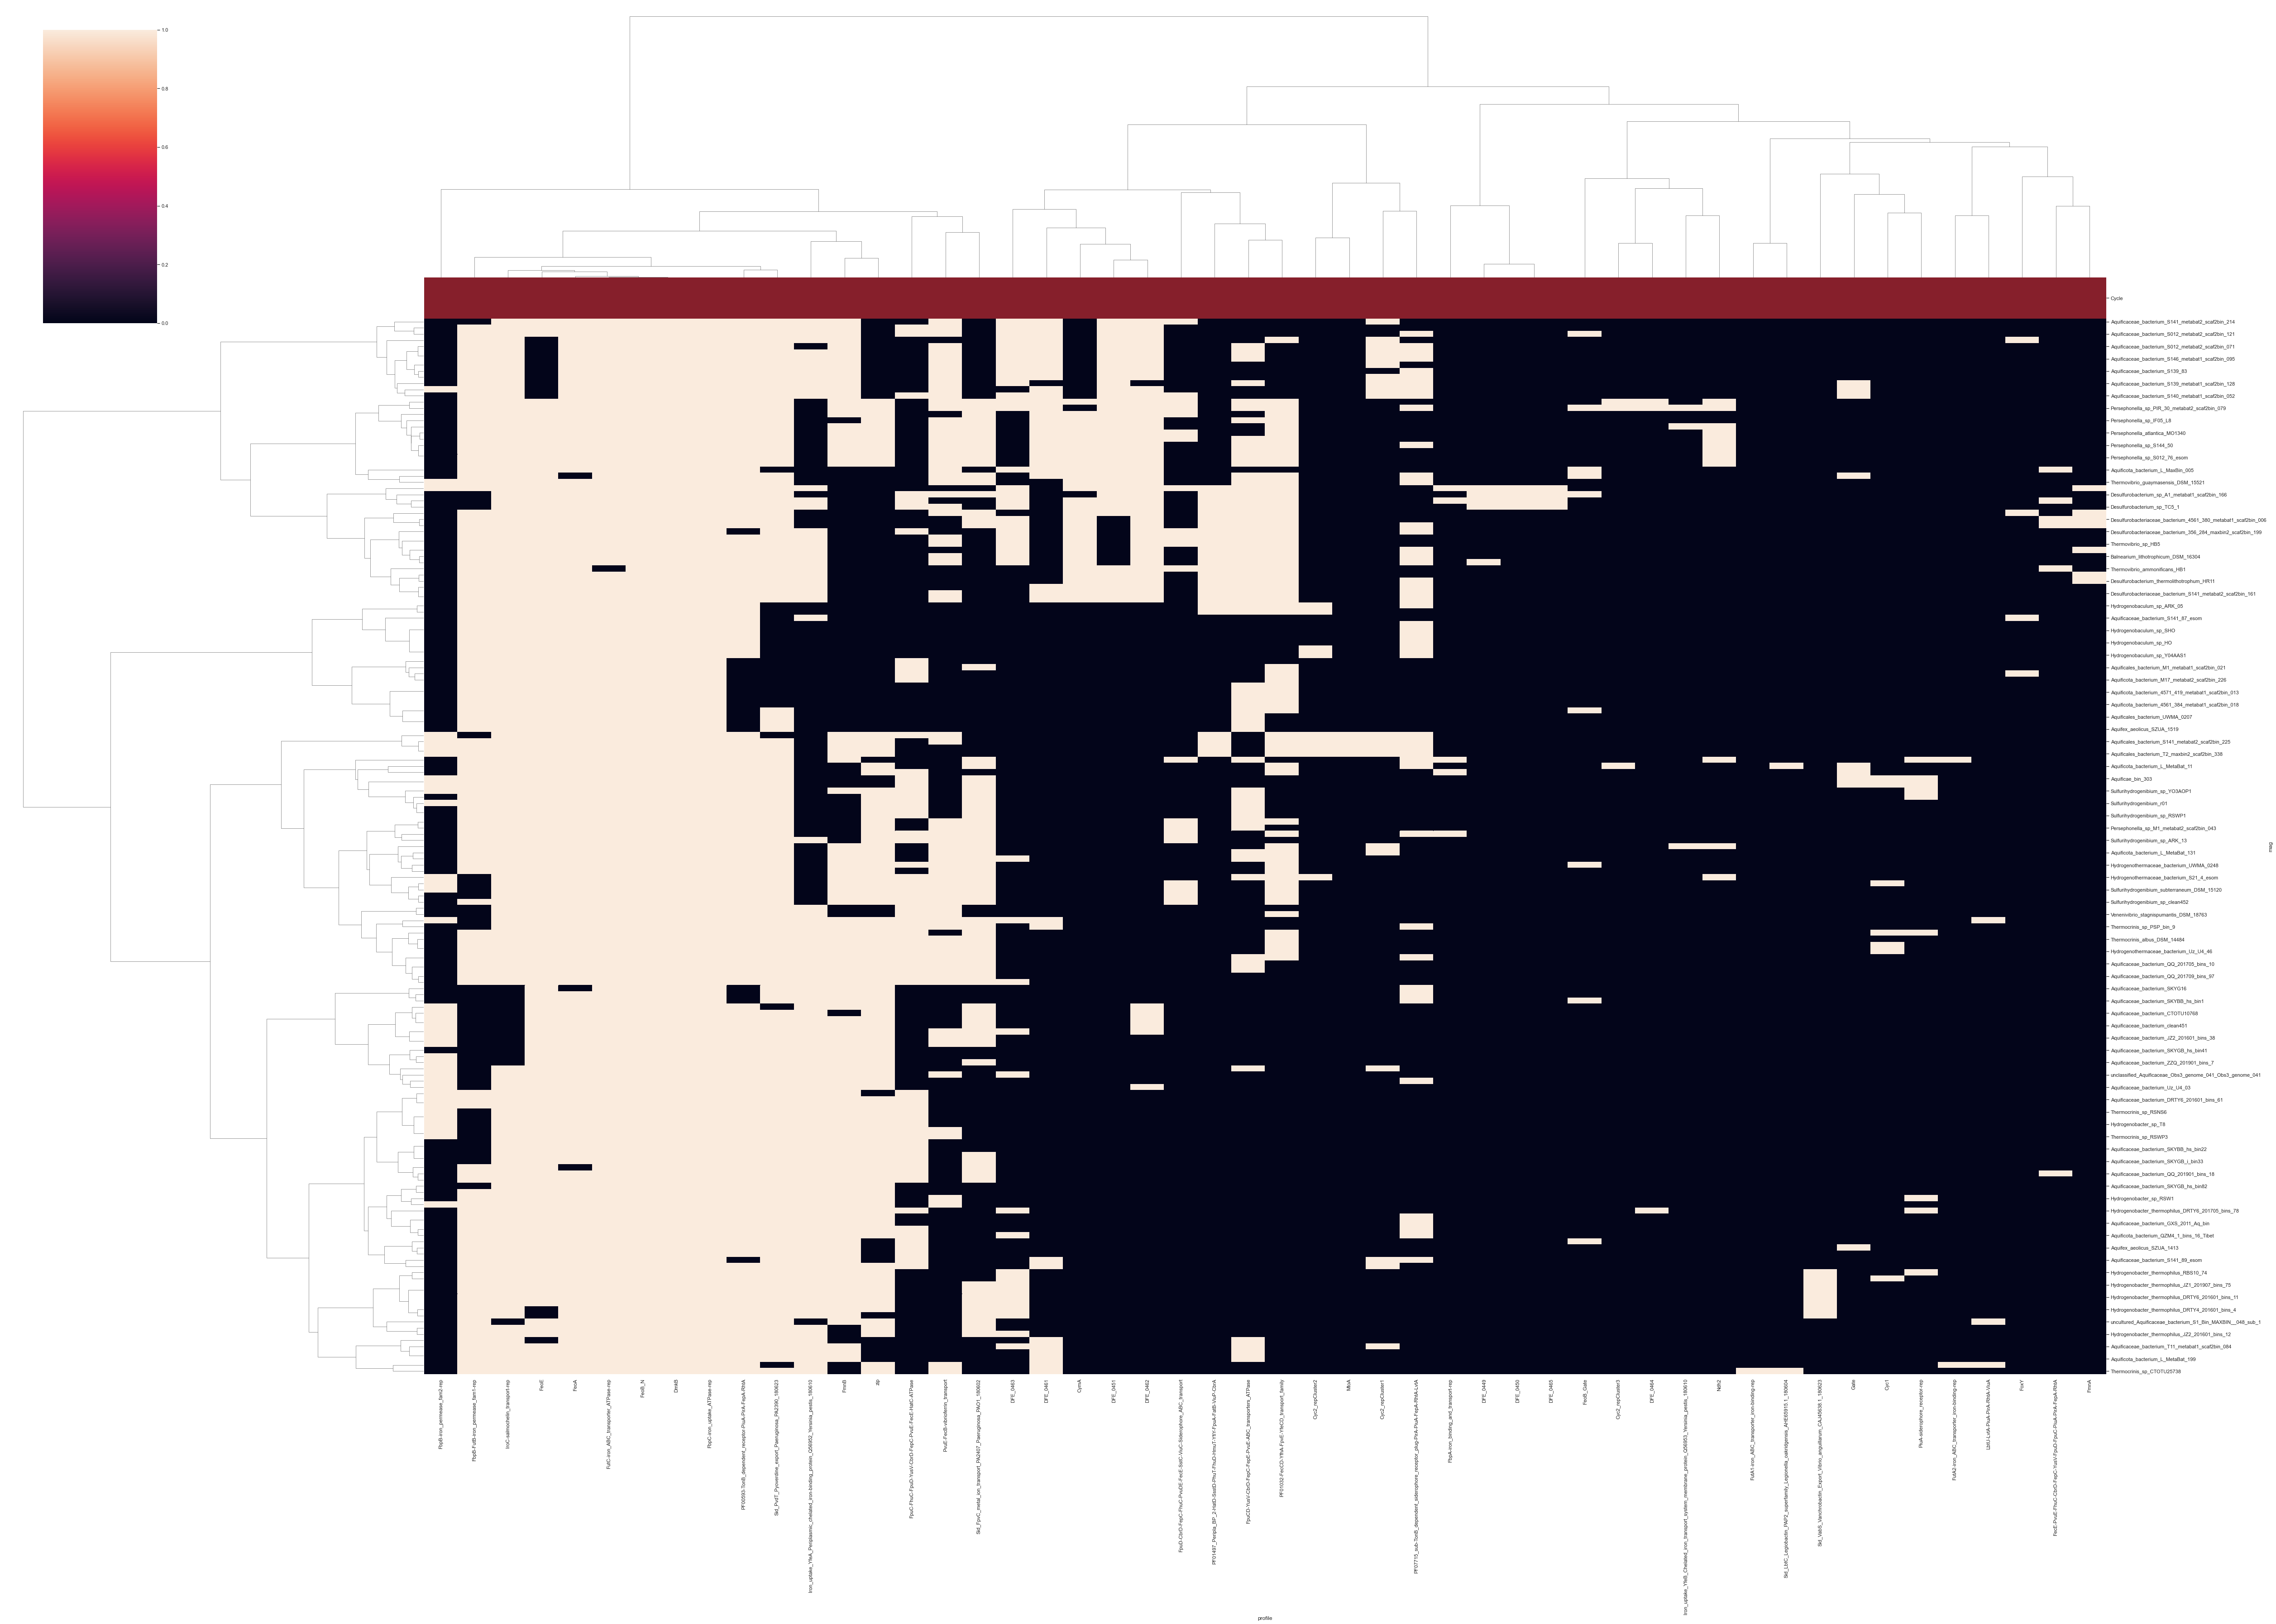

In [68]:
sns.set(font_scale=1.0)

for cycle in metadata_df["Cycle"].unique():

    cycle_hmm_models = metadata_df[
        metadata_df["Cycle"] == cycle
    ]["hmm_model"].unique()

    heat_df_cycle = heat_df[[
        col for col in heat_df.columns
        if col in cycle_hmm_models
    ]]

    try:
        print(f"[+] Clustermap for cycle {cycle}")
        sns.clustermap(
            data=heat_df_cycle,
            method=CLUSTERMAP_METHOD,
            metric=CLUSTERMAP_METRIC,
            col_colors=cycle_colors,
            figsize=(70, 50)
        )
        plt.savefig(
            os.path.join(
                DATA_DIR,
                f"heatmap-{'-'.join(SOURCES)}-cycle-{cycle.lower()}.svg"
            ),
            # dpi=300
        )
        plt.show()

    except Exception as error:
        print(f"[ERROR] Could not create clustermap for cycle {cycle}:", error)
        plt.close()


## HMM importance

In [69]:
X = heat_df.copy()

# Get families in the same order as in heat_df
y = tax_df.set_index("Genomes").loc[heat_df.index]["Family"]

# Encode as categories
family_mapping = {family: idx for idx, family in enumerate(y.unique())}
y = y.map(family_mapping)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_SEED
)

In [70]:
estimator = RandomForestClassifier(
    n_estimators=5,
    random_state=RANDOM_SEED
)
estimator.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=666)

In [71]:
print(family_mapping)
print()
print(
    classification_report(
        y_true=y_test,
        y_pred=estimator.predict(X_test)
    )
)

{'Aquificaceae': 0, 'QOAS01': 1, 'Hydrogenothermaceae': 2, 'Desulfurobacteriaceae': 3}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         4
           2       0.92      1.00      0.96        12
           3       1.00      0.83      0.91         6

    accuracy                           0.98        52
   macro avg       0.98      0.96      0.97        52
weighted avg       0.98      0.98      0.98        52



In [72]:

result = permutation_importance(
    estimator,
    X_test,
    y_test,
    n_repeats=20,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

forest_importances = pd.DataFrame({
        "feature": X_test.columns,
        "mean": result.importances_mean,
        "std": result.importances_std
}).sort_values("mean", ascending=False)

fig = px.bar(
    data_frame=forest_importances,
    x="feature",
    y="mean",
    error_y="std",
    labels={
        "feature": "HMM model",
        "mean": "Mean accuracy decrease",
        "std": "Mean accuracy decrease (std)"
    },
    title="HMM model importances",
    template="plotly_white",
    height=900
)
fig.show()